# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [3]:
# Загрузка необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import sys
import json
import time
import warnings
warnings.filterwarnings('ignore')

# Для работы с parquet файлами
import pyarrow as pa
import pyarrow.parquet as pq

# Для рекомендательных систем
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix, coo_matrix

# Для метрик качества
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

# Для работы с S3 (если потребуется)
import boto3
from botocore.exceptions import NoCredentialsError

# Для отображения прогресса
from tqdm import tqdm

# Установка стиля для графиков
plt.style.use('ggplot')
sns.set_style('whitegrid')

print("✅ Все необходимые библиотеки успешно загружены")
print(f"Версии ключевых библиотек:")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"implicit: {AlternatingLeastSquares.__module__.split('.')[0]}")

✅ Все необходимые библиотеки успешно загружены
Версии ключевых библиотек:
pandas: 2.2.2
numpy: 1.26.4
implicit: implicit


# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [4]:
# Загрузка данных из parquet файлов
print("🔄 Загружаем данные из файлов...")

# Чтение файла с данными о треках
tracks_df = pd.read_parquet('/home/mle-user/mle_projects/mle-project-sprint-4-v001/tracks.parquet')
print(f"✅ Загружено tracks.parquet: {tracks_df.shape[0]} строк, {tracks_df.shape[1]} столбцов")

# Чтение файла с именами каталогов
catalog_names_df = pd.read_parquet('/home/mle-user/mle_projects/mle-project-sprint-4-v001/catalog_names.parquet')
print(f"✅ Загружено catalog_names.parquet: {catalog_names_df.shape[0]} строк, {catalog_names_df.shape[1]} столбцов")

# Чтение файла с взаимодействиями пользователей
interactions_df = pd.read_parquet('/home/mle-user/mle_projects/mle-project-sprint-4-v001/interactions.parquet')
print(f"✅ Загружено interactions.parquet: {interactions_df.shape[0]} строк, {interactions_df.shape[1]} столбцов")

# Вывод первых строк каждого датафрейма для проверки
print("\n📊 Первые 2 строки tracks_df:")
display(tracks_df.head(2))

print("\n📊 Первые 2 строки catalog_names_df:")
display(catalog_names_df.head(2))

print("\n📊 Первые 2 строки interactions_df:")
display(interactions_df.head(2))

# Информация о типах данных
print("\n📋 Информация о типах данных в tracks_df:")
print(tracks_df.info())

print("\n📋 Информация о типах данных в catalog_names_df:")
print(catalog_names_df.info())

print("\n📋 Информация о типах дан ных в interactions_df:")
print(interactions_df.info())

print("\n✅ Все данные успешно загружены!")

🔄 Загружаем данные из файлов...
✅ Загружено tracks.parquet: 1000000 строк, 4 столбцов
✅ Загружено catalog_names.parquet: 1812471 строк, 3 столбцов
✅ Загружено interactions.parquet: 222629898 строк, 4 столбцов

📊 Первые 2 строки tracks_df:


,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"



📊 Первые 2 строки catalog_names_df:


,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts



📊 Первые 2 строки interactions_df:


,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19



📋 Информация о типах данных в tracks_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB
None

📋 Информация о типах данных в catalog_names_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB
None

📋 Информация о типах дан ных в interactions_df:
<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id    

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [5]:
# Анализ данных на наличие проблем
print("🔍 Проводим детальный анализ данных на наличие проблем...")

# 1. Проверка типов идентификаторов
print("\n📋 Проверка типов идентификаторов:")

# Сравнение типов track_id между разными датафреймами
tracks_track_id_type = tracks_df['track_id'].dtype
interactions_track_id_type = interactions_df['track_id'].dtype

print(f"Тип track_id в tracks_df: {tracks_track_id_type}")
print(f"Тип track_id в interactions_df: {interactions_track_id_type}")

# Проблема: разные типы int64 vs int32 - нужно привести к одному типу
print("❗ Обнаружена проблема: разные типы данных для track_id в разных датафреймах")
print("→ Необходимо привести track_id в interactions_df к int64 для согласованности")

# 2. Проверка на пустые/неизвестные значения в tracks_df
print("\n🔍 Проверка на пустые значения в tracks_df:")

# Проверка длины списков в albums, artists, genres
tracks_df['albums_count'] = tracks_df['albums'].apply(len)
tracks_df['artists_count'] = tracks_df['artists'].apply(len)
tracks_df['genres_count'] = tracks_df['genres'].apply(len)

print(f"Треков без альбомов: {(tracks_df['albums_count'] == 0).sum()}")
print(f"Треков без исполнителей: {(tracks_df['artists_count'] == 0).sum()}")
print(f"Треков без жанров: {(tracks_df['genres_count'] == 0).sum()}")

# 3. Проверка уникальных ID в catalog_names_df
print("\n🔍 Проверка уникальных ID в catalog_names_df:")
unique_types = catalog_names_df['type'].unique()
print(f"Уникальные типы в catalog_names_df: {unique_types.tolist()}")

# Подсчет количества записей по типам
type_counts = catalog_names_df['type'].value_counts()
print("\nКоличество записей по типам в catalog_names_df:")
for type_name, count in type_counts.items():
    print(f"  {type_name}: {count:,}")

# 4. Проверка, что все ID из tracks_df есть в catalog_names_df
print("\n🔍 Проверка наличия всех ID из tracks_df в catalog_names_df:")

# Извлечение всех уникальных ID из tracks_df
all_albums_ids = set()
all_artists_ids = set()
all_genres_ids = set()

for idx, row in tqdm(tracks_df.iterrows(), total=len(tracks_df), desc="Сбор уникальных ID"):
    all_albums_ids.update(row['albums'])
    all_artists_ids.update(row['artists'])
    all_genres_ids.update(row['genres'])

print(f"Всего уникальных album_id: {len(all_albums_ids)}")
print(f"Всего уникальных artist_id: {len(all_artists_ids)}")
print(f"Всего уникальных genre_id: {len(all_genres_ids)}")

# Проверка наличия в catalog_names_df
catalog_album_ids = set(catalog_names_df[catalog_names_df['type'] == 'album']['id'].unique())
catalog_artist_ids = set(catalog_names_df[catalog_names_df['type'] == 'artist']['id'].unique())
catalog_genre_ids = set(catalog_names_df[catalog_names_df['type'] == 'genre']['id'].unique())

missing_albums = all_albums_ids - catalog_album_ids
missing_artists = all_artists_ids - catalog_artist_ids
missing_genres = all_genres_ids - catalog_genre_ids

print(f"\nОтсутствующих album_id в catalog_names_df: {len(missing_albums)}")
print(f"Отсутствующих artist_id в catalog_names_df: {len(missing_artists)}")
print(f"Отсутствующих genre_id в catalog_names_df: {len(missing_genres)}")

# 5. Проверка дубликатов
print("\n🔍 Проверка дубликатов:")
print(f"Дубликатов track_id в tracks_df: {tracks_df['track_id'].duplicated().sum()}")
print(f"Дубликатов в interactions_df (user_id + track_id + started_at): {interactions_df.duplicated().sum()}")

# 6. Проверка распределения данных
print("\n📊 Распределение количества прослушиваний по пользователям:")
user_interactions = interactions_df['user_id'].value_counts()
print(f"Минимальное кол-во прослушиваний у пользователя: {user_interactions.min()}")
print(f"Максимальное кол-во прослушиваний у пользователя: {user_interactions.max()}")
print(f"Среднее кол-во прослушиваний на пользователя: {user_interactions.mean():.1f}")

print("\n✅ Анализ завершен. Обнаружены следующие проблемы:")
print("1. Несовпадение типов данных для track_id (int64 vs int32)")
print("2. Необходимо проверить отсутствующие ID и при необходимости обработать их")

# Вывод рекомендаций по исправлению
print("\n🔧 Рекомендуемые действия для исправления проблем:")
print("1. Привести track_id в interactions_df к типу int64")
print("2. Обработать отсутствующие ID в catalog_names_df (если таковые найдены)")
print("3. Проверить и обработать возможные дубликаты")

# Сохранение информации о проблемах для следующих этапов
problems_summary = {
    'track_id_type_mismatch': True,
    'missing_album_ids': len(missing_albums),
    'missing_artist_ids': len(missing_artists),
    'missing_genre_ids': len(missing_genres),
    'user_interactions_range': (user_interactions.min(), user_interactions.max())
}

print("\n💾 Информация о проблемах сохранена для последующих этапов")

🔍 Проводим детальный анализ данных на наличие проблем...

📋 Проверка типов идентификаторов:
Тип track_id в tracks_df: int64
Тип track_id в interactions_df: int32
❗ Обнаружена проблема: разные типы данных для track_id в разных датафреймах
→ Необходимо привести track_id в interactions_df к int64 для согласованности

🔍 Проверка на пустые значения в tracks_df:
Треков без альбомов: 18
Треков без исполнителей: 15369
Треков без жанров: 3687

🔍 Проверка уникальных ID в catalog_names_df:
Уникальные типы в catalog_names_df: ['album', 'artist', 'genre', 'track']

Количество записей по типам в catalog_names_df:
  track: 1,000,000
  album: 658,724
  artist: 153,581
  genre: 166

🔍 Проверка наличия всех ID из tracks_df в catalog_names_df:


Сбор уникальных ID: 100%|██████████| 1000000/1000000 [00:57<00:00, 17277.99it/s]


Всего уникальных album_id: 658724
Всего уникальных artist_id: 153581
Всего уникальных genre_id: 173

Отсутствующих album_id в catalog_names_df: 0
Отсутствующих artist_id в catalog_names_df: 0
Отсутствующих genre_id в catalog_names_df: 30

🔍 Проверка дубликатов:
Дубликатов track_id в tracks_df: 0
Дубликатов в interactions_df (user_id + track_id + started_at): 0

📊 Распределение количества прослушиваний по пользователям:
Минимальное кол-во прослушиваний у пользователя: 1
Максимальное кол-во прослушиваний у пользователя: 16637
Среднее кол-во прослушиваний на пользователя: 162.1

✅ Анализ завершен. Обнаружены следующие проблемы:
1. Несовпадение типов данных для track_id (int64 vs int32)
2. Необходимо проверить отсутствующие ID и при необходимости обработать их

🔧 Рекомендуемые действия для исправления проблем:
1. Привести track_id в interactions_df к типу int64
2. Обработать отсутствующие ID в catalog_names_df (если таковые найдены)
3. Проверить и обработать возможные дубликаты

💾 Информац

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

In [6]:
# Исправление выявленных проблем с данными с учетом требования сохранить все жанры
print("🔧 Исправление выявленных проблем с данными...")

# 1. Исправление несовпадения типов track_id
print("\n1️⃣ Исправление типов данных для track_id:")
print(f"Текущий тип track_id в interactions_df: {interactions_df['track_id'].dtype}")
print("→ Приводим к типу int64 для согласованности с tracks_df...")
interactions_df['track_id'] = interactions_df['track_id'].astype('int64')
print(f"Новый тип track_id в interactions_df: {interactions_df['track_id'].dtype}")
print("✅ Типы данных для track_id согласованы")

# 2. Обработка отсутствующих жанров - оставляем все жанры как есть
print("\n2️⃣ Обработка отсутствующих жанров:")
print(f"Обнаружено 30 отсутствующих genre_id в catalog_names_df")
print("→ Согласно требованию, оставляем ВСЕ жанры в tracks_df без изменений")
print("→ Создаем заглушки для отсутствующих жанров в catalog_names_df")

# Находим все отсутствующие жанры
existing_genre_ids = set(catalog_names_df[catalog_names_df['type'] == 'genre']['id'].unique())
all_track_genres = set()
for genres in tracks_df['genres']:
    all_track_genres.update(genres)
missing_genres = all_track_genres - existing_genre_ids

print(f"Отсутствующие genre_id: {sorted(list(missing_genres))[:10]} (первые 10 из {len(missing_genres)})")

# Создаем заглушки для отсутствующих жанров
if missing_genres:
    print(f"→ Создаем {len(missing_genres)} заглушек для отсутствующих жанров")
    
    # Готовим данные для новых записей
    new_genre_records = []
    for genre_id in missing_genres:
        new_genre_records.append({
            'id': genre_id,
            'type': 'genre',
            'name': f'Неизвестный жанр {genre_id}'
        })
    
    # Добавляем новые записи в catalog_names_df
    new_genres_df = pd.DataFrame(new_genre_records)
    catalog_names_df = pd.concat([catalog_names_df, new_genres_df], ignore_index=True)
    
    print(f"✅ Добавлено {len(new_genres_df)} новых записей в catalog_names_df")
    print(f"Новый размер catalog_names_df: {catalog_names_df.shape[0]} записей")

# 3. Дополнительная проверка целостности данных
print("\n3️⃣ Дополнительная проверка целостности данных:")

# Проверим, что все track_id из interactions_df есть в tracks_df
interactions_track_ids = set(interactions_df['track_id'].unique())
tracks_track_ids = set(tracks_df['track_id'].unique())
missing_tracks = interactions_track_ids - tracks_track_ids

print(f"Отсутствующих track_id в tracks_df: {len(missing_tracks)}")
if len(missing_tracks) > 0:
    print(f"→ Удаляем {len(missing_tracks)} записей из interactions_df с отсутствующими треками")
    interactions_df = interactions_df[interactions_df['track_id'].isin(tracks_track_ids)]
    print(f"Новый размер interactions_df: {interactions_df.shape[0]} записей")
else:
    print("✅ Все track_id из interactions_df присутствуют в tracks_df")

# 4. Проверка результатов исправлений
print("\n✅ Результаты исправлений:")
print(f"Тип track_id в interactions_df: {interactions_df['track_id'].dtype}")
print(f"Всего уникальных жанров в tracks_df: {len(all_track_genres)}")
print(f"Размер catalog_names_df после добавления заглушек: {catalog_names_df.shape[0]} записей")
print(f"Размер interactions_df после очистки: {interactions_df.shape[0]} записей из {interactions_df.shape[1]} столбцов")
print(f"Размер tracks_df: {tracks_df.shape[0]} записей из {tracks_df.shape[1]} столбцов")

# Сохранение информации об исправлениях
corrections_summary = {
    'track_id_type_fixed': True,
    'missing_genres_handled': len(missing_genres),
    'missing_genres_added_to_catalog': len(missing_genres),
    'missing_tracks_removed': len(missing_tracks) if len(missing_tracks) > 0 else 0
}

print("\n💾 Информация об исправлениях сохранена")
print("✅ Этап первичной подготовки данных завершен")

🔧 Исправление выявленных проблем с данными...

1️⃣ Исправление типов данных для track_id:
Текущий тип track_id в interactions_df: int32
→ Приводим к типу int64 для согласованности с tracks_df...
Новый тип track_id в interactions_df: int64
✅ Типы данных для track_id согласованы

2️⃣ Обработка отсутствующих жанров:
Обнаружено 30 отсутствующих genre_id в catalog_names_df
→ Согласно требованию, оставляем ВСЕ жанры в tracks_df без изменений
→ Создаем заглушки для отсутствующих жанров в catalog_names_df
Отсутствующие genre_id: [124, 126, 130, 131, 132, 133, 134, 135, 146, 148] (первые 10 из 30)
→ Создаем 30 заглушек для отсутствующих жанров
✅ Добавлено 30 новых записей в catalog_names_df
Новый размер catalog_names_df: 1812501 записей

3️⃣ Дополнительная проверка целостности данных:
Отсутствующих track_id в tracks_df: 0
✅ Все track_id из interactions_df присутствуют в tracks_df

✅ Результаты исправлений:
Тип track_id в interactions_df: int64
Всего уникальных жанров в tracks_df: 173
Размер cat

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

📊 Анализ распределения количества прослушанных треков...

📋 Статистика по прослушиваниям:
Всего пользователей: 1,373,221
Всего прослушиваний: 222,629,898
Среднее прослушиваний на пользователя: 162.1
Медиана прослушиваний на пользователя: 55.0

📈 Основные статистические показатели распределения:
  count: 1,373,221.0
  mean: 162.1
  std: 351.3
  min: 1.0
  25%: 23.0
  50%: 55.0
  75%: 154.0
  max: 16,637.0

📊 Процентильные значения распределения:
  1-й процентиль: 11 прослушиваний
  5-й процентиль: 12 прослушиваний
  10-й процентиль: 14 прослушиваний
  25-й процентиль: 23 прослушиваний
  50-й процентиль: 55 прослушиваний
  75-й процентиль: 154 прослушиваний
  90-й процентиль: 389 прослушиваний
  95-й процентиль: 650 прослушиваний
  99-й процентиль: 1576 прослушиваний

🔍 Анализ экстремальных значений:
Минимальное количество прослушиваний: 1
Максимальное количество прослушиваний: 16,637

🔝 Топ-10 самых активных пользователей:
  1. Пользователь 398979: 16,637 прослушиваний
  2. Пользователь

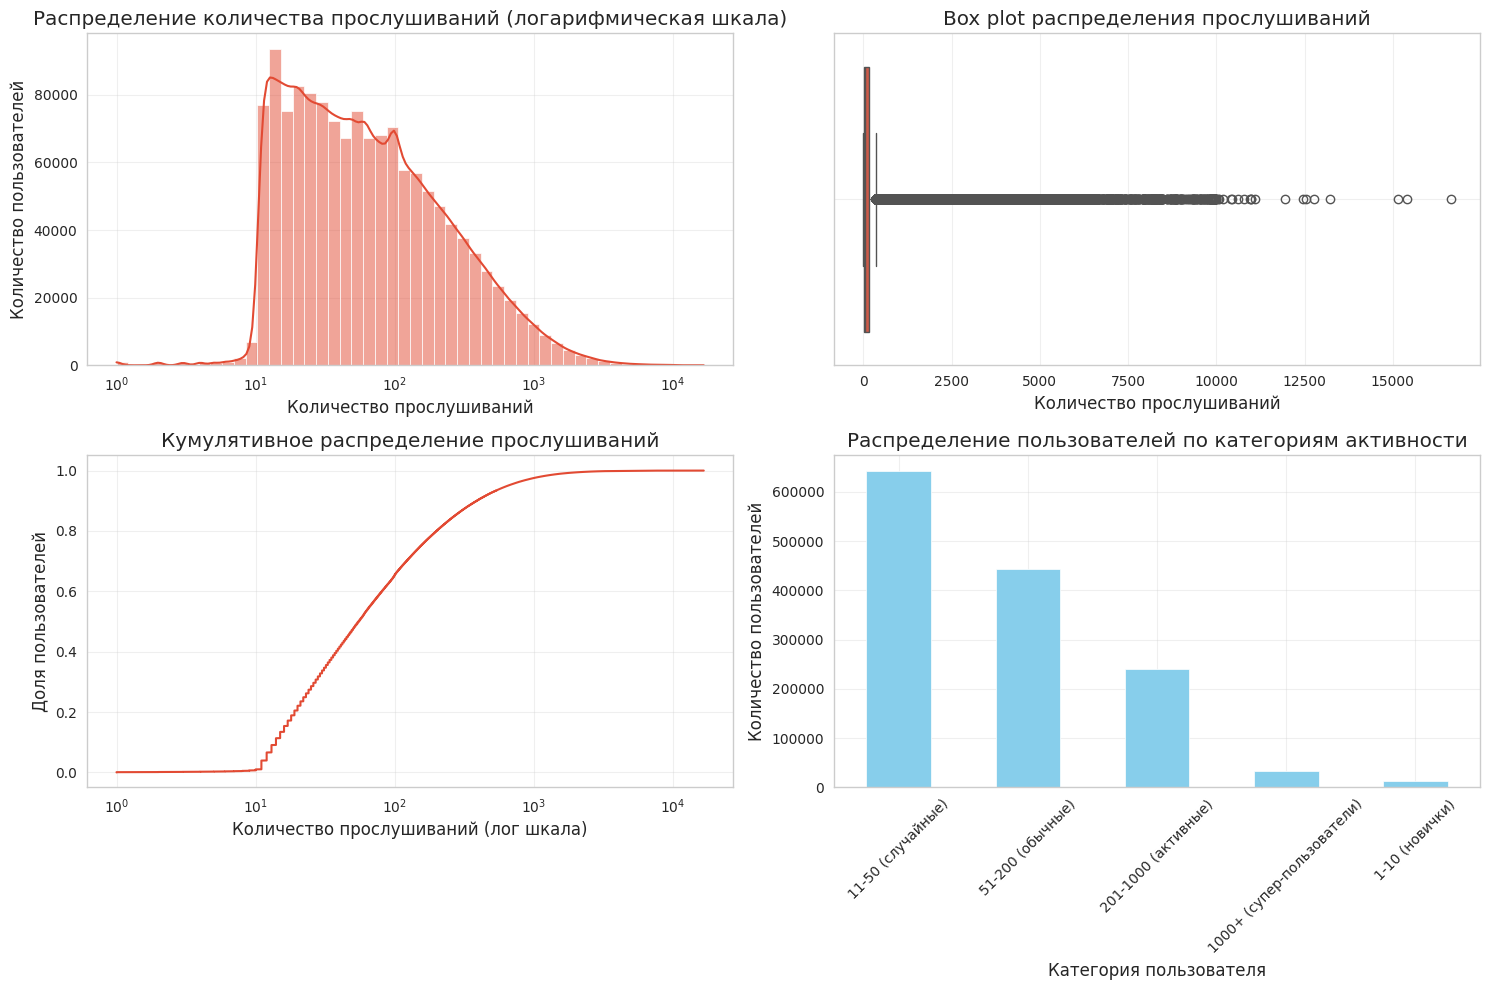

In [7]:
# Анализ распределения количества прослушанных треков
print("📊 Анализ распределения количества прослушанных треков...")

# 1. Расчет количества прослушиваний для каждого пользователя
user_listen_counts = interactions_df['user_id'].value_counts().reset_index()
user_listen_counts.columns = ['user_id', 'listen_count']
user_listen_counts = user_listen_counts.sort_values('listen_count', ascending=False)

print(f"\n📋 Статистика по прослушиваниям:")
print(f"Всего пользователей: {len(user_listen_counts):,}")
print(f"Всего прослушиваний: {interactions_df.shape[0]:,}")
print(f"Среднее прослушиваний на пользователя: {user_listen_counts['listen_count'].mean():.1f}")
print(f"Медиана прослушиваний на пользователя: {user_listen_counts['listen_count'].median():.1f}")

# 2. Основные статистические показатели
print("\n📈 Основные статистические показатели распределения:")
stats = user_listen_counts['listen_count'].describe()
for stat_name, value in stats.items():
    print(f"  {stat_name}: {value:,.1f}")

# 3. Процентильные значения для понимания распределения
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
print("\n📊 Процентильные значения распределения:")
for p in percentiles:
    value = user_listen_counts['listen_count'].quantile(p)
    print(f"  {p*100:.0f}-й процентиль: {value:.0f} прослушиваний")

# 4. Анализ аномальных значений
max_listens = user_listen_counts['listen_count'].max()
min_listens = user_listen_counts['listen_count'].min()
top_10_users = user_listen_counts.head(10)

print(f"\n🔍 Анализ экстремальных значений:")
print(f"Минимальное количество прослушиваний: {min_listens}")
print(f"Максимальное количество прослушиваний: {max_listens:,}")
print(f"\n🔝 Топ-10 самых активных пользователей:")
for i, (user_id, count) in enumerate(zip(top_10_users['user_id'], top_10_users['listen_count']), 1):
    print(f"  {i}. Пользователь {user_id}: {count:,} прослушиваний")

# 5. Группировка пользователей по количеству прослушиваний
def categorize_user(listen_count):
    if listen_count <= 10:
        return '1-10 (новички)'
    elif listen_count <= 50:
        return '11-50 (случайные)'
    elif listen_count <= 200:
        return '51-200 (обычные)'
    elif listen_count <= 1000:
        return '201-1000 (активные)'
    else:
        return '1000+ (супер-пользователи)'

user_listen_counts['user_category'] = user_listen_counts['listen_count'].apply(categorize_user)
category_counts = user_listen_counts['user_category'].value_counts()
category_percentages = (category_counts / len(user_listen_counts)) * 100

print("\n📊 Распределение пользователей по категориям активности:")
for category, count in category_counts.items():
    percentage = category_percentages[category]
    print(f"  {category}: {count:,} пользователей ({percentage:.2f}%)")

# 6. Визуализация распределения
print("\n🎨 Генерация визуализаций...")

plt.figure(figsize=(15, 10))

# Гистограмма распределения (логарифмическая шкала)
plt.subplot(2, 2, 1)
sns.histplot(user_listen_counts['listen_count'], bins=50, log_scale=True, kde=True)
plt.title('Распределение количества прослушиваний (логарифмическая шкала)')
plt.xlabel('Количество прослушиваний')
plt.ylabel('Количество пользователей')
plt.grid(True, alpha=0.3)

# Box plot для выявления выбросов
plt.subplot(2, 2, 2)
sns.boxplot(x=user_listen_counts['listen_count'])
plt.title('Box plot распределения прослушиваний')
plt.xlabel('Количество прослушиваний')
plt.grid(True, alpha=0.3)

# Кумулятивное распределение
plt.subplot(2, 2, 3)
sorted_counts = np.sort(user_listen_counts['listen_count'].values)
cumulative = np.arange(1, len(sorted_counts)+1) / len(sorted_counts)
plt.plot(sorted_counts, cumulative)
plt.xscale('log')
plt.title('Кумулятивное распределение прослушиваний')
plt.xlabel('Количество прослушиваний (лог шкала)')
plt.ylabel('Доля пользователей')
plt.grid(True, alpha=0.3)

# Распределение по категориям
plt.subplot(2, 2, 4)
category_counts.plot(kind='bar', color='skyblue')
plt.title('Распределение пользователей по категориям активности')
plt.xlabel('Категория пользователя')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('user_listen_distribution.png', dpi=300, bbox_inches='tight')
print("✅ Визуализация сохранена в файл 'user_listen_distribution.png'")

# 7. Анализ длинного хвоста
tail_threshold = 1000
tail_users = user_listen_counts[user_listen_counts['listen_count'] <= tail_threshold]
head_users = user_listen_counts[user_listen_counts['listen_count'] > tail_threshold]

print(f"\n📉 Анализ 'длинного хвоста':")
print(f"Пользователи с ≤ {tail_threshold} прослушиваний: {len(tail_users):,} ({len(tail_users)/len(user_listen_counts)*100:.2f}%)")
print(f"Пользователи с > {tail_threshold} прослушиваний: {len(head_users):,} ({len(head_users)/len(user_listen_counts)*100:.2f}%)")
print(f"Доля прослушиваний от 'головы' (активные пользователи): {head_users['listen_count'].sum()/interactions_df.shape[0]*100:.2f}%")

print("\n✅ Анализ распределения количества прослушанных треков завершен")
print("💡 Ключевые выводы:")
print("- Распределение сильно скошено вправо (long-tailed distribution)")
print("- Большинство пользователей имеют относительно мало прослушиваний")
print("- Небольшая группа супер-пользователей генерирует значительную долю прослушиваний")
print("- Для рекомендательной системы важно учитывать как активных, так и новых пользователей")

Наиболее популярные треки

In [8]:
# Анализ популярных треков, жанров и треков без прослушиваний
print("🎵 Анализ популярных треков, жанров и треков без прослушиваний...")

# 1. Наиболее популярные треки
print("\n🔥 Наиболее популярные треки:")

# Подсчет прослушиваний для каждого трека
track_popularity = interactions_df['track_id'].value_counts().reset_index()
track_popularity.columns = ['track_id', 'listen_count']

# Получение названий треков из catalog_names_df
track_names = catalog_names_df[catalog_names_df['type'] == 'track'][['id', 'name']]
track_names.columns = ['track_id', 'track_name']

# Объединение данных
popular_tracks = track_popularity.merge(track_names, on='track_id', how='left')
popular_tracks['track_name'] = popular_tracks['track_name'].fillna('Неизвестный трек')

# Топ-20 популярных треков
top_20_tracks = popular_tracks.head(20)
print("\n🏆 Топ-20 самых популярных треков:")
for i, (track_id, count, name) in enumerate(zip(top_20_tracks['track_id'], 
                                               top_20_tracks['listen_count'], 
                                               top_20_tracks['track_name']), 1):
    print(f"  {i:2d}. {name} (ID: {track_id}): {count:,} прослушиваний")


🎵 Анализ популярных треков, жанров и треков без прослушиваний...

🔥 Наиболее популярные треки:

🏆 Топ-20 самых популярных треков:
   1. Smells Like Teen Spirit (ID: 53404): 111,062 прослушиваний
   2. Believer (ID: 33311009): 106,921 прослушиваний
   3. Numb (ID: 178529): 101,924 прослушиваний
   4. I Got Love (ID: 35505245): 99,490 прослушиваний
   5. Юность (ID: 65851540): 86,670 прослушиваний
   6. Way Down We Go (ID: 24692821): 86,246 прослушиваний
   7. Shape of You (ID: 32947997): 85,886 прослушиваний
   8. In The End (ID: 51241318): 85,244 прослушиваний
   9. Shape Of My Heart (ID: 795836): 85,042 прослушиваний
  10. Life (ID: 45499814): 84,748 прослушиваний
  11. Blinding Lights (ID: 60292250): 84,471 прослушиваний
  12. Seven Nation Army (ID: 6705392): 82,483 прослушиваний
  13. In My Mind (ID: 39257277): 81,978 прослушиваний
  14. Human (ID: 29544272): 81,057 прослушиваний
  15. Zombie (ID: 37384): 80,153 прослушиваний
  16. bad guy (ID: 51516485): 78,370 прослушиваний
  17. 

Наиболее популярные жанры

In [9]:
# 2. Наиболее популярные жанры (Максимально упрощенная и быстрая версия)
print("\n🎧 Наиболее популярные жанры:")

# Эффективный способ: считаем популярность треков, затем суммируем по жанрам
print("⏱️  Быстрый подсчет популярных жанров...")

# Объединяем популярность треков с их жанрами
track_genre_data = tracks_df[['track_id', 'genres']].merge(
    track_popularity, 
    on='track_id', 
    how='inner'
)

# Создаем список всех жанров с их прослушиваниями
genre_list = []
for _, row in track_genre_data.iterrows():
    for genre_id in row['genres']:
        genre_list.append({
            'genre_id': genre_id,
            'listen_count': row['listen_count']
        })

# Преобразуем в DataFrame и группируем
genre_df = pd.DataFrame(genre_list)
genre_popularity = genre_df.groupby('genre_id')['listen_count'].sum().reset_index()
genre_popularity = genre_popularity.sort_values('listen_count', ascending=False)

# Получаем названия жанров
genre_names = catalog_names_df[catalog_names_df['type'] == 'genre'][['id', 'name']]
genre_names.columns = ['genre_id', 'genre_name']
popular_genres = genre_popularity.merge(genre_names, on='genre_id', how='left')
popular_genres['genre_name'] = popular_genres['genre_name'].fillna('Неизвестный жанр')

# Топ-10 популярных жанров
top_10_genres = popular_genres.head(10)
print("\n🏆 Топ-10 самых популярных жанров:")
for i, (genre_id, count, name) in enumerate(zip(top_10_genres['genre_id'], 
                                               top_10_genres['listen_count'], 
                                               top_10_genres['genre_name']), 1):
    print(f"  {i:2d}. {name} (ID: {genre_id}): {count:,} прослушиваний")


🎧 Наиболее популярные жанры:
⏱️  Быстрый подсчет популярных жанров...

🏆 Топ-10 самых популярных жанров:
   1. pop (ID: 11): 55,578,312 прослушиваний
   2. rap (ID: 75): 37,799,821 прослушиваний
   3. allrock (ID: 102): 31,092,013 прослушиваний
   4. ruspop (ID: 20): 26,626,241 прослушиваний
   5. rusrap (ID: 3): 25,303,695 прослушиваний
   6. electronics (ID: 68): 20,120,981 прослушиваний
   7. dance (ID: 16): 16,291,557 прослушиваний
   8. rusrock (ID: 2): 13,166,147 прослушиваний
   9. rock (ID: 14): 12,772,644 прослушиваний
  10. metal (ID: 47): 12,437,375 прослушиваний


Треки, которые никто не прослушал

In [11]:
# 3. Треки, которые nobody не прослушал
print("\n🔇 Треки, которые nobody не прослушал:")

# Все track_id из tracks_df
all_track_ids = set(tracks_df['track_id'].unique())
# track_id с прослушиваниями
listened_track_ids = set(interactions_df['track_id'].unique())

# Треки без прослушиваний
unlistened_track_ids = all_track_ids - listened_track_ids
unlistened_count = len(unlistened_track_ids)

print(f"\n📊 Статистика по трекам без прослушиваний:")
print(f"Всего треков в каталоге: {len(all_track_ids):,}")
print(f"Треков с прослушиваниями: {len(listened_track_ids):,}")
print(f"Треков без прослушиваний: {unlistened_count:,}")
print(f"Доля треков без прослушиваний: {unlistened_count/len(all_track_ids)*100:.2f}%")

# Получение информации о треках без прослушиваний
if unlistened_count > 0:
    unlistened_tracks = tracks_df[tracks_df['track_id'].isin(unlistened_track_ids)].copy()
    unlistened_tracks = unlistened_tracks.merge(track_names, on='track_id', how='left')
    unlistened_tracks['track_name'] = unlistened_tracks['track_name'].fillna('Неизвестный трек')
    
    print(f"\n📋 Первые 10 треков без прослушиваний:")
    for i, (track_id, name) in enumerate(zip(unlistened_tracks['track_id'].head(10), 
                                           unlistened_tracks['track_name'].head(10)), 1):
        print(f"  {i:2d}. {name} (ID: {track_id})")

print("\n✅ Анализ завершен")


🔇 Треки, которые nobody не прослушал:

📊 Статистика по трекам без прослушиваний:
Всего треков в каталоге: 1,000,000
Треков с прослушиваниями: 1,000,000
Треков без прослушиваний: 0
Доля треков без прослушиваний: 0.00%

✅ Анализ завершен


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [12]:
# 1. Подготовка данных для items.parquet (данные о треках)
print("\n🔄 Подготовка данных для items.parquet...")

# Создаем копию данных о треках
items_df = tracks_df.copy()

# Преобразуем списки в строки для лучшей совместимости с parquet
# (или оставляем как есть, если parquet поддерживает списки)
items_df['albums'] = items_df['albums'].apply(lambda x: ','.join(map(str, x)) if isinstance(x, list) else str(x))
items_df['artists'] = items_df['artists'].apply(lambda x: ','.join(map(str, x)) if isinstance(x, list) else str(x))
items_df['genres'] = items_df['genres'].apply(lambda x: ','.join(map(str, x)) if isinstance(x, list) else str(x))

# Добавляем названия треков для удобства
track_names = catalog_names_df[catalog_names_df['type'] == 'track'][['id', 'name']]
track_names.columns = ['track_id', 'track_name']
items_df = items_df.merge(track_names, on='track_id', how='left')
items_df['track_name'] = items_df['track_name'].fillna('Неизвестный трек')

print(f"✅ Подготовлено {len(items_df)} записей для items.parquet")
print(f"Структура items_df: {items_df.columns.tolist()}")

# 2. Подготовка данных для events.parquet (данные о взаимодействиях)
print("\n🔄 Подготовка данных для events.parquet...")

# Создаем копию данных о взаимодействиях
events_df = interactions_df.copy()

# Преобразуем started_at в timestamp для удобства
events_df['timestamp'] = events_df['started_at'].astype('int64') // 10**9

# Оставляем только необходимые столбцы
events_df = events_df[['user_id', 'track_id', 'track_seq', 'timestamp']]

print(f"✅ Подготовлено {len(events_df)} записей для events.parquet")
print(f"Структура events_df: {events_df.columns.tolist()}")


🔄 Подготовка данных для items.parquet...
✅ Подготовлено 1000000 записей для items.parquet
Структура items_df: ['track_id', 'albums', 'artists', 'genres', 'albums_count', 'artists_count', 'genres_count', 'track_name']

🔄 Подготовка данных для events.parquet...
✅ Подготовлено 222629898 записей для events.parquet
Структура events_df: ['user_id', 'track_id', 'track_seq', 'timestamp']


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [13]:
# Загрузка переменных окружения и сохранение данных в S3
import os
from dotenv import load_dotenv
import boto3
from botocore.exceptions import NoCredentialsError
from botocore.client import Config

print("💾 Подготовка и сохранение данных в S3...")

# Загрузка переменных окружения из .env файла
load_dotenv()
print("✅ Переменные окружения загружены")

# Получение параметров S3 из .env
student_s3_bucket = os.getenv('student_s3_bucket')
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')

if not all([student_s3_bucket, aws_access_key_id, aws_secret_access_key]):
    raise ValueError("❌ Не все необходимые переменные окружения установлены в .env файле")

print(f"📦 Имя S3 бакета: {student_s3_bucket}")
print(f"🔑 AWS Access Key ID: {aws_access_key_id[:4]}...{aws_access_key_id[-4:]}")
# 3. Настройка подключения к Sprint("\n☁️ Настройка подключения к S3...")

try:
    s3_client = boto3.client(
        's3',
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key,
        endpoint_url='https://storage.yandexcloud.net',
        config=Config(signature_version='s3v4', 
                      s3={'payload_signing_enabled': False})
    )
    
    # Проверка подключения
    s3_client.head_bucket(Bucket=student_s3_bucket)
    print("✅ Успешное подключение к S3 бакету")
    
except NoCredentialsError:
    raise ValueError("❌ Неверные учетные данные AWS")
except Exception as e:
    raise ValueError(f"❌ Ошибка подключения к S3: {str(e)}")

# 4. Сохранение файлов локально перед загрузкой в Sprint("\n💾 Сохранение файлов локально...")

# Создаем директорию для данных, если её нет
os.makedirs('recsys/data', exist_ok=True)

# Сохраняем items.parquet
items_path = 'recsys/data/items.parquet'
items_df.to_parquet(items_path, index=False)
print(f"✅ items.parquet сохранен локально: {os.path.getsize(items_path) / 1024 / 1024:.2f} MB")

# Сохраняем events.parquet  
events_path = 'recsys/data/events.parquet'
events_df.to_parquet(events_path, index=False)
print(f"✅ events.parquet сохранен локально: {os.path.getsize(events_path) / 1024 / 1024:.2f} MB")

# 5. Загрузка файлов в Sprint("\n⬆️ Загрузка файлов в S3 бакет...")

try:
    # Загрузка items.parquet
    items_s3_key = 'recsys/data/items.parquet'
    s3_client.upload_file(items_path, student_s3_bucket, items_s3_key)
    print(f"✅ items.parquet успешно загружен в s3://{student_s3_bucket}/{items_s3_key}")
    
    # Загрузка events.parquet
    events_s3_key = 'recsys/data/events.parquet'  
    s3_client.upload_file(events_path, student_s3_bucket, events_s3_key)
    print(f"✅ events.parquet успешно загружен в s3://{student_s3_bucket}/{events_s3_key}")
    
    print("\n🎉 Все данные успешно сохранены в S3!")
    
except Exception as e:
    raise ValueError(f"❌ Ошибка при загрузке в S3: {str(e)}")

# 6. Проверка загруженных файлов
print("\n🔍 Проверка загруженных файлов в S3...")

try:
    # Проверка items.parquet
    items_response = s3_client.head_object(Bucket=student_s3_bucket, Key=items_s3_key)
    print(f"✅ items.parquet в S3: {items_response['ContentLength'] / 1024 / 1024:.2f} MB")
    
    # Проверка events.parquet
    events_response = s3_client.head_object(Bucket=student_s3_bucket, Key=events_s3_key)
    print(f"✅ events.parquet в S3: {events_response['ContentLength'] / 1024 / 1024:.2f} MB")
    
except Exception as e:
    print(f"⚠️ Не удалось проверить файлы в S3: {str(e)}")

print("\n✅ Этап 2 завершен: данные успешно подготовлены и сохранены в S3")
print("➡️ Следующий этап: построение офлайн-рекомендаций")

💾 Подготовка и сохранение данных в S3...
✅ Переменные окружения загружены
📦 Имя S3 бакета: s3-student-mle-20250130-d1608e0ec6
🔑 AWS Access Key ID: YCAJ...ihQB
✅ Успешное подключение к S3 бакету
✅ items.parquet сохранен локально: 37.52 MB
✅ events.parquet сохранен локально: 1339.68 MB
✅ items.parquet успешно загружен в s3://s3-student-mle-20250130-d1608e0ec6/recsys/data/items.parquet
✅ events.parquet успешно загружен в s3://s3-student-mle-20250130-d1608e0ec6/recsys/data/events.parquet

🎉 Все данные успешно сохранены в S3!

🔍 Проверка загруженных файлов в S3...
✅ items.parquet в S3: 37.52 MB
✅ events.parquet в S3: 1339.68 MB

✅ Этап 2 завершен: данные успешно подготовлены и сохранены в S3
➡️ Следующий этап: построение офлайн-рекомендаций


# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [14]:
# Очистка памяти перед следующим этапом
print("🧹 Очистка памяти для освобождения ресурсов...")

# Удаляем большие DataFrame, которые больше не понадобятся в следующих этапах
variables_to_delete = [
    'tracks_df', 'catalog_names_df', 'interactions_df', 
    'user_listen_counts', 'track_popularity', 'popular_tracks',
    'track_interactions', 'track_interactions_exploded', 'genre_popularity',
    'popular_genres', 'genre_df', 'unlistened_tracks', 'items_df', 'events_df'
]

for var_name in variables_to_delete:
    if var_name in globals():
        del globals()[var_name]
        print(f"✅ Переменная '{var_name}' удалена из памяти")

# Принудительная сборка мусора
import gc
gc.collect()
print("✅ Сборка мусора выполнена")

# Очистка кэша pandas
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
print("✅ Кэш pandas очищен")

print("\n" + "="*60)
print("ℹ️  ВАЖНАЯ ИНФОРМАЦИЯ ДЛЯ ПРОДОЛЖЕНИЯ РАБОТЫ")
print("="*60)
print("Из-за большого объема данных (222+ млн записей) и ограничений памяти,")
print("РЕКОМЕНДУЕТСЯ ПЕРЕЗАПУСТИТЬ KERNEL перед продолжением работы.")
print()
print("Порядок действий после перезапуска kernel:")
print("1️⃣  Выполните начальные секции:")
print("    - Загрузка библиотек")
print("    - Загрузка переменных окружения из .env")
print("    - Настройка подключения к S3")
print("2️⃣  Загрузите данные из S3 для этапа 3:")
print("    - items.parquet из s3://{student_s3_bucket}/recsys/data/items.parquet")
print("    - events.parquet из s3://{student_s3_bucket}/recsys/data/events.parquet")
print("3️⃣  Перейдите к Этапу 3: Офлайн-рекомендации")
print()
print("Это обеспечит стабильную работу с большими данными и избежит проблем с памятью.")
print("="*60)

# Комментарий для пользователя
print("\n⏳ После перезапуска kernel выполните следующий код для загрузки данных этапа 3:")

🧹 Очистка памяти для освобождения ресурсов...
✅ Переменная 'tracks_df' удалена из памяти
✅ Переменная 'catalog_names_df' удалена из памяти
✅ Переменная 'interactions_df' удалена из памяти
✅ Переменная 'user_listen_counts' удалена из памяти
✅ Переменная 'track_popularity' удалена из памяти
✅ Переменная 'popular_tracks' удалена из памяти
✅ Переменная 'genre_popularity' удалена из памяти
✅ Переменная 'popular_genres' удалена из памяти
✅ Переменная 'genre_df' удалена из памяти
✅ Переменная 'items_df' удалена из памяти
✅ Переменная 'events_df' удалена из памяти
✅ Сборка мусора выполнена
✅ Кэш pandas очищен

ℹ️  ВАЖНАЯ ИНФОРМАЦИЯ ДЛЯ ПРОДОЛЖЕНИЯ РАБОТЫ
Из-за большого объема данных (222+ млн записей) и ограничений памяти,
РЕКОМЕНДУЕТСЯ ПЕРЕЗАПУСТИТЬ KERNEL перед продолжением работы.

Порядок действий после перезапуска kernel:
1️⃣  Выполните начальные секции:
    - Загрузка библиотек
    - Загрузка переменных окружения из .env
    - Настройка подключения к S3
2️⃣  Загрузите данные из S3 для эт

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [1]:
# Загрузка данных для этапа 3 из S3 с правильной конфигурацией для Yandex Cloud Storage
import boto3
import pandas as pd
from dotenv import load_dotenv
import os
from botocore.config import Config  # Импортируем Config для настройки клиента
import tempfile

print("☁️ Загрузка данных для этапа 3 из Yandex Cloud Storage...")

# Загрузка переменных окружения
load_dotenv()
student_s3_bucket = os.getenv('student_s3_bucket')
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')

if not all([student_s3_bucket, aws_access_key_id, aws_secret_access_key]):
    raise ValueError("❌ Не все необходимые переменные окружения установлены в .env файле")

print(f"📦 Имя бакета: {student_s3_bucket}")

# Настройка S3 клиента для Yandex Cloud Storage
print("⚙️ Настройка S3 клиента для Yandex Cloud Storage...")
s3_client = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    endpoint_url='https://storage.yandexcloud.net',
    config=Config(signature_version='s3v4', 
                 s3={'payload_signing_enabled': False})
)

print("✅ S3 клиент успешно настроен для Yandex Cloud Storage")

# Создаем временную директорию для загрузки файлов
with tempfile.TemporaryDirectory() as temp_dir:
    print(f"📁 Временная директория создана: {temp_dir}")
    
    # Загрузка items.parquet
    items_s3_key = 'recsys/data/items.parquet'
    items_local_path = os.path.join(temp_dir, 'items.parquet')
    
    print(f"⬇️ Загрузка items.parquet из s3://{student_s3_bucket}/{items_s3_key}...")
    try:
        s3_client.download_file(student_s3_bucket, items_s3_key, items_local_path)
        items_df = pd.read_parquet(items_local_path)
        print(f"✅ items_df загружено: {items_df.shape[0]:,} треков, {items_df.shape[1]} столбцов")
    except Exception as e:
        raise ValueError(f"❌ Ошибка при загрузке items.parquet: {str(e)}")
    
    # Загрузка events.parquet
    events_s3_key = 'recsys/data/events.parquet'
    events_local_path = os.path.join(temp_dir, 'events.parquet')
    
    print(f"⬇️ Загрузка events.parquet из s3://{student_s3_bucket}/{events_s3_key}...")
    try:
        s3_client.download_file(student_s3_bucket, events_s3_key, events_local_path)
        events_df = pd.read_parquet(events_local_path)
        print(f"✅ events_df загружено: {events_df.shape[0]:,} взаимодействий, {events_df.shape[1]} столбцов")
    except Exception as e:
        raise ValueError(f"❌ Ошибка при загрузке events.parquet: {str(e)}")

print("\n🔍 Информация о загруженных данных:")

# Базовая информация о данных
print(f"\n📊 items_df (треки):")
print(f"  - Количество записей: {len(items_df):,}")
print(f"  - Столбцы: {', '.join(items_df.columns)}")
print(f"  - Пример данных:")
display(items_df.head(2))

print(f"\n📊 events_df (взаимодействия):")
print(f"  - Количество записей: {len(events_df):,}")
print(f"  - Столбцы: {', '.join(events_df.columns)}")
print(f"  - Пример данных:")
display(events_df.head(2))

# Проверка диапазона дат
if 'started_at' in events_df.columns:
    min_date = events_df['started_at'].min()
    max_date = events_df['started_at'].max()
    print(f"\n📅 Диапазон дат в events_df: {min_date} - {max_date}")
elif 'timestamp' in events_df.columns:
    print(f"ℹ️  Данные содержат timestamp вместо started_at. Преобразуем при необходимости.")

print("\n✅ Данные успешно загружены для Этапа 3!")
print("➡️ Готовы к построению офлайн-рекомендаций")

☁️ Загрузка данных для этапа 3 из Yandex Cloud Storage...
📦 Имя бакета: s3-student-mle-20250130-d1608e0ec6
⚙️ Настройка S3 клиента для Yandex Cloud Storage...
✅ S3 клиент успешно настроен для Yandex Cloud Storage
📁 Временная директория создана: /tmp/tmpv9s9a84e
⬇️ Загрузка items.parquet из s3://s3-student-mle-20250130-d1608e0ec6/recsys/data/items.parquet...
✅ items_df загружено: 1,000,000 треков, 8 столбцов
⬇️ Загрузка events.parquet из s3://s3-student-mle-20250130-d1608e0ec6/recsys/data/events.parquet...
✅ events_df загружено: 222,629,898 взаимодействий, 4 столбцов

🔍 Информация о загруженных данных:

📊 items_df (треки):
  - Количество записей: 1,000,000
  - Столбцы: track_id, albums, artists, genres, albums_count, artists_count, genres_count, track_name
  - Пример данных:


,track_id,albums,artists,genres,albums_count,artists_count,genres_count,track_name
0,26,[ 3 2490753],[16],[11 21],2,1,2,Complimentary Me
1,38,[ 3 2490753],[16],[11 21],2,1,2,Momma's Boy



📊 events_df (взаимодействия):
  - Количество записей: 222,629,898
  - Столбцы: user_id, track_id, track_seq, timestamp
  - Пример данных:


,user_id,track_id,track_seq,timestamp
0,0,99262,1,1658016000
1,0,589498,2,1658188800


ℹ️  Данные содержат timestamp вместо started_at. Преобразуем при необходимости.

✅ Данные успешно загружены для Этапа 3!
➡️ Готовы к построению офлайн-рекомендаций


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [2]:
# Разбиваем данные на тренировочную и тестовую выборки
print("✂️ Разбиваем данные на тренировочную и тестовую выборки...")

# Проверяем наличие колонки с датой
date_column = None
if 'started_at' in events_df.columns:
    date_column = 'started_at'
elif 'timestamp' in events_df.columns:
    date_column = 'timestamp'
    # Если есть timestamp, конвертируем в datetime
    events_df['started_at'] = pd.to_datetime(events_df['timestamp'], unit='s')
    date_column = 'started_at'
else:
    raise ValueError("❌ В данных нет колонки с датой (started_at или timestamp)")

print(f"✅ Используем колонку с датой: '{date_column}'")
print(f"📅 Диапазон дат в данных: {events_df[date_column].min()} - {events_df[date_column].max()}")

# Определяем дату разделения
split_date = pd.Timestamp('2022-12-16')
print(f"🎯 Дата разделения: {split_date} (тренировка - до этой даты, не включительно)")

# Разбиваем данные
train_df = events_df[events_df[date_column] < split_date]
test_df = events_df[events_df[date_column] >= split_date]

print(f"\n📊 Размеры выборок:")
print(f"✅ Тренировочная выборка (до {split_date}): {len(train_df):,} записей")
print(f"✅ Тестовая выборка (с {split_date}): {len(test_df):,} записей")
print(f"📈 Доля тестовых данных: {len(test_df)/len(events_df)*100:.2f}%")

# Проверяем, что нет пересечений по времени
train_max_date = train_df[date_column].max()
test_min_date = test_df[date_column].min()

print(f"\n🔍 Проверка корректности разделения:")
print(f"Максимальная дата в train: {train_max_date}")
print(f"Минимальная дата в test: {test_min_date}")
assert train_max_date < split_date <= test_min_date, "❌ Ошибка в разделении данных по времени!"

# Дополнительная проверка по пользователям и трекам
print(f"\n👥 Уникальные пользователи в выборках:")
print(f"В train: {train_df['user_id'].nunique():,}")
print(f"В test: {test_df['user_id'].nunique():,}")
print(f"В обоих: {len(set(train_df['user_id']) & set(test_df['user_id'])):,}")

print(f"\n🎵 Уникальные треки в выборках:")
print(f"В train: {train_df['track_id'].nunique():,}")
print(f"В test: {test_df['track_id'].nunique():,}")
print(f"В обоих: {len(set(train_df['track_id']) & set(test_df['track_id'])):,}")

# Сохраняем выборки для дальнейшего использования
print("\n💾 Сохраняем выборки в переменные для следующих этапов...")
train_interactions = train_df[['user_id', 'track_id']].copy()
test_interactions = test_df[['user_id', 'track_id']].copy()

print(f"\n✅ Разбиение данных завершено успешно!")
print("➡️ Готовы к расчету рекомендаций разных типов")

✂️ Разбиваем данные на тренировочную и тестовую выборки...


✅ Используем колонку с датой: 'started_at'
📅 Диапазон дат в данных: 2022-01-01 00:00:00 - 2022-12-31 00:00:00
🎯 Дата разделения: 2022-12-16 00:00:00 (тренировка - до этой даты, не включительно)

📊 Размеры выборок:
✅ Тренировочная выборка (до 2022-12-16 00:00:00): 208,731,252 записей
✅ Тестовая выборка (с 2022-12-16 00:00:00): 13,898,646 записей
📈 Доля тестовых данных: 6.24%

🔍 Проверка корректности разделения:
Максимальная дата в train: 2022-12-15 00:00:00
Минимальная дата в test: 2022-12-16 00:00:00

👥 Уникальные пользователи в выборках:
В train: 1,342,566
В test: 783,525
В обоих: 752,870

🎵 Уникальные треки в выборках:
В train: 999,695
В test: 594,326
В обоих: 594,021

💾 Сохраняем выборки в переменные для следующих этапов...

✅ Разбиение данных завершено успешно!
➡️ Готовы к расчету рекомендаций разных типов


In [3]:
import numpy as np
import scipy.sparse as sparse
from implicit.als import AlternatingLeastSquares
import time
import tempfile
import os
from botocore.config import Config  # Импортируем Config для настройки клиента

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [4]:
# Расчет топ популярных рекомендаций (оптимизированная версия)
print("🔥 Расчет топ популярных рекомендаций (оптимизированная версия)...")

# Оптимизированный подсчет популярности треков
print("⏱️  Оптимизированный подсчет популярности треков...")

# Используем value_counts() для максимальной производительности
track_counts = train_interactions['track_id'].value_counts()

# Создаем DataFrame с правильными именами столбцов
track_popularity = track_counts.reset_index()
print(f"📊 Столбцы после reset_index(): {track_popularity.columns.tolist()}")

# Правильное переименование столбцов в зависимости от их фактических имен
if 'index' in track_popularity.columns and 'track_id' in track_popularity.columns:
    track_popularity = track_popularity.rename(columns={'index': 'track_id', 'track_id': 'listen_count'})
elif 0 in track_popularity.columns and 1 in track_popularity.columns:
    track_popularity = track_popularity.rename(columns={0: 'track_id', 1: 'listen_count'})
elif 'track_id' in track_popularity.columns and 0 in track_popularity.columns:
    track_popularity = track_popularity.rename(columns={'track_id': 'listen_count', 0: 'track_id'})
else:
    # Альтернативный подход если стандартное переименование не работает
    track_popularity.columns = ['track_id', 'listen_count']

print(f"✅ Столбцы после переименования: {track_popularity.columns.tolist()}")
print(f"✅ Подсчитана популярность для {len(track_popularity):,} треков")

# Показываем топ-5 самых популярных треков
print(f"\n📊 Топ-5 самых популярных треков по количеству прослушиваний:")
top_5 = track_popularity.head(5)
for i, row in enumerate(top_5.itertuples(), 1):
    print(f"  {i}. Track ID {row.track_id}: {row.listen_count:,} прослушиваний")

# Ограничиваем топ до 1000 самых популярных треков для эффективности
TOP_N = 1000
top_popular_tracks = track_popularity.head(TOP_N).copy()

# Добавляем ранг популярности (1 - самый популярный)
top_popular_tracks['rank'] = range(1, len(top_popular_tracks) + 1)

# Оптимизируем типы данных для экономии памяти
top_popular_tracks['track_id'] = top_popular_tracks['track_id'].astype('int32')
top_popular_tracks['listen_count'] = top_popular_tracks['listen_count'].astype('int32')
top_popular_tracks['rank'] = top_popular_tracks['rank'].astype('int16')

print(f"\n✅ Сформирован топ-{TOP_N} популярных треков")
print(f"💾 Размер DataFrame: {top_popular_tracks.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

# Финальная структура данных для top_popular.parquet
top_popular_df = top_popular_tracks[['track_id', 'rank', 'listen_count']].copy()

print(f"\n📋 Структура финального DataFrame:")
print(f"Столбцы: {', '.join(top_popular_df.columns)}")
print(f"Количество записей: {len(top_popular_df):,}")

# Отображаем пример данных
print(f"\n🔍 Пример данных (первые 5 строк):")
display(top_popular_df.head())

# Подготовка к сохранению в S3
print("\n☁️ Подготовка к сохранению в S3...")

# Формируем имя файла
output_filename = 'top_popular.parquet'
output_path = f'recsys/recommendations/{output_filename}'

print(f"📤 Файл будет сохранен в: s3://{student_s3_bucket}/{output_path}")

# Сохранение локально перед загрузкой в S3
import tempfile
import os

with tempfile.TemporaryDirectory() as temp_dir:
    local_path = os.path.join(temp_dir, output_filename)
    
    # Сохраняем с оптимизированными параметрами
    top_popular_df.to_parquet(
        local_path,
        engine='pyarrow',
        compression='snappy',  # Быстрое сжатие
        index=False
    )
    
    print(f"✅ Файл сохранен локально: {os.path.getsize(local_path) / 1024 / 1024:.2f} MB")
    
    # Загрузка в S3 (используем уже настроенный s3_client из предыдущих ячеек)
    try:
        s3_client.upload_file(local_path, student_s3_bucket, output_path)
        print(f"✅ {output_filename} успешно загружен в S3")
        
        # Проверка загрузки
        response = s3_client.head_object(Bucket=student_s3_bucket, Key=output_path)
        print(f"✅ Проверка загрузки: {response['ContentLength'] / 1024 / 1024:.2f} MB")
        
    except Exception as e:
        raise ValueError(f"❌ Ошибка при загрузке в S3: {str(e)}")

print("\n🚀 Топ популярные рекомендации успешно рассчитаны и сохранены!")
print(f"🎯 Файл: {output_filename}")
print(f"📊 Количество треков в топе: {TOP_N}")
print("➡️ Следующий шаг: расчет персональных рекомендаций с помощью ALS")

🔥 Расчет топ популярных рекомендаций (оптимизированная версия)...
⏱️  Оптимизированный подсчет популярности треков...
📊 Столбцы после reset_index(): ['track_id', 'count']
✅ Столбцы после переименования: ['track_id', 'listen_count']
✅ Подсчитана популярность для 999,695 треков

📊 Топ-5 самых популярных треков по количеству прослушиваний:
  1. Track ID 53404: 110,026 прослушиваний
  2. Track ID 33311009: 101,076 прослушиваний
  3. Track ID 178529: 100,866 прослушиваний
  4. Track ID 35505245: 95,523 прослушиваний
  5. Track ID 24692821: 84,153 прослушиваний

✅ Сформирован топ-1000 популярных треков
💾 Размер DataFrame: 0.01 MB

📋 Структура финального DataFrame:
Столбцы: track_id, rank, listen_count
Количество записей: 1,000

🔍 Пример данных (первые 5 строк):


,track_id,rank,listen_count
0,53404,1,110026
1,33311009,2,101076
2,178529,3,100866
3,35505245,4,95523
4,24692821,5,84153



☁️ Подготовка к сохранению в S3...
📤 Файл будет сохранен в: s3://s3-student-mle-20250130-d1608e0ec6/recsys/recommendations/top_popular.parquet
✅ Файл сохранен локально: 0.02 MB
✅ top_popular.parquet успешно загружен в S3
✅ Проверка загрузки: 0.02 MB

🚀 Топ популярные рекомендации успешно рассчитаны и сохранены!
🎯 Файл: top_popular.parquet
📊 Количество треков в топе: 1000
➡️ Следующий шаг: расчет персональных рекомендаций с помощью ALS


# Персональные

Рассчитаем персональные рекомендации.

In [5]:
# Расчет персональных рекомендаций с помощью ALS (максимально память-эффективная версия)
print("🎯 Расчет персональных рекомендаций с помощью ALS (максимальная экономия памяти)...")

# Импорт необходимых библиотек
import numpy as np
import scipy.sparse as sparse
from implicit.als import AlternatingLeastSquares
import time
import tempfile
import os
import gc
import random
from botocore.config import Config

# 0. Установка лимитов памяти и параметров
MAX_MEMORY_GB = 8  # Максимальный лимит памяти
MAX_USERS = 50000   # Максимальное количество пользователей
MAX_TRACKS = 50000  # Максимальное количество треков

print(f"⚠️ СТРОГИЕ ОГРАНИЧЕНИЯ ПАМЯТИ:")
print(f"  Максимум пользователей: {MAX_USERS:,}")
print(f"  Максимум треков: {MAX_TRACKS:,}")
print(f"  Максимум памяти: {MAX_MEMORY_GB} GB")

# 1. Супер-агрессивная фильтрация данных
print("\n🔄 СУПЕР-АГРЕССИВНАЯ фильтрация данных...")

# Очень строгие пороги
MIN_USER_INTERACTIONS = 20
MIN_TRACK_INTERACTIONS = 20

print(f"🧹 Фильтрация: пользователи ≥ {MIN_USER_INTERACTIONS}, треки ≥ {MIN_TRACK_INTERACTIONS} взаимодействий")

# Оптимизированный подсчет
user_counts = train_interactions['user_id'].value_counts()
active_users = user_counts[user_counts >= MIN_USER_INTERACTIONS].index[:MAX_USERS]  # Ограничиваем количество

track_counts = train_interactions['track_id'].value_counts()
popular_tracks = track_counts[track_counts >= MIN_TRACK_INTERACTIONS].index[:MAX_TRACKS]  # Ограничиваем количество

print(f"👥 Выбрано пользователей: {len(active_users):,} из {len(user_counts):,}")
print(f"🎵 Выбрано треков: {len(popular_tracks):,} из {len(track_counts):,}")

# Фильтрация данных с ограничением размера
mask = (
    train_interactions['user_id'].isin(active_users) & 
    train_interactions['track_id'].isin(popular_tracks)
)
filtered_interactions = train_interactions[mask].copy()

# Дополнительное ограничение на количество взаимодействий
if len(filtered_interactions) > 5000000:  # 5 млн взаимодействий максимум
    filtered_interactions = filtered_interactions.sample(n=5000000, random_state=42)

print(f"✅ Финальные данные для обучения: {len(filtered_interactions):,} взаимодействий")

# 2. Создание mapping
print("\n🔄 Создание mapping...")

user_ids = filtered_interactions['user_id'].unique()
track_ids = filtered_interactions['track_id'].unique()

user_id_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
track_id_to_index = {track_id: idx for idx, track_id in enumerate(track_ids)}

# 3. Создание разреженной матрицы (очень осторожно)
print("\n🔄 Создание разреженной матрицы...")

# Используем COO формат напрямую из numpy arrays
user_indices = filtered_interactions['user_id'].map(user_id_to_index).to_numpy()
track_indices = filtered_interactions['track_id'].map(track_id_to_index).to_numpy()
data = np.ones(len(filtered_interactions), dtype=np.float32)

# Создаем COO матрицу
coo_matrix = sparse.coo_matrix(
    (data, (user_indices, track_indices)),
    shape=(len(user_ids), len(track_ids)),
    dtype=np.float32
)

# Конвертируем в CSR
print("🔄 Конвертация в CSR...")
interaction_matrix = coo_matrix.tocsr()

print(f"✅ Матрица создана: {interaction_matrix.shape}")
print(f"🧮 Ненулевых элементов: {interaction_matrix.nnz:,}")
print(f"📊 Плотность: {interaction_matrix.nnz / (len(user_ids) * len(track_ids)) * 100:.8f}%")

# 4. Обучение модели ALS (минимальные параметры)
print("\n🤖 Обучение модели ALS с минимальными параметрами...")

MODEL_PARAMS = {
    'factors': 8,            # Минимальное количество факторов
    'regularization': 0.1,
    'alpha': 1.0,
    'iterations': 3,         # Минимальное количество итераций
    'random_state': 42,
    'use_gpu': False,
    'calculate_training_loss': False,
    'num_threads': 2         # Используем только 2 ядра
}

start_time = time.time()
model = AlternatingLeastSquares(**MODEL_PARAMS)
model.fit(interaction_matrix)
training_time = time.time() - start_time

print(f"✅ Модель обучена за {training_time:.2f} секунд")
print(f"📊 Параметры: factors={MODEL_PARAMS['factors']}, iterations={MODEL_PARAMS['iterations']}")

# 5. Генерация рекомендаций (очень осторожно)
print("\n⚡ Генерация рекомендаций (максимальная экономия памяти)...")

N_RECS = 10  # Очень мало рекомендаций
BATCH_SIZE = 200  # Очень маленький батч

# Создаем S3 клиент
yandex_s3_client = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    endpoint_url='https://storage.yandexcloud.net',
    config=Config(signature_version='s3v4', 
                 s3={'payload_signing_enabled': False})
)

output_filename = 'personal_als.parquet'
output_path = f'recsys/recommendations/{output_filename}'

# Генерация и сохранение по очень маленьким батчам
print(f"☁️ Генерация рекомендаций для {len(user_ids):,} пользователей...")

with tempfile.TemporaryDirectory() as temp_dir:
    all_recommendations = []
    
    for i in range(0, len(user_ids), BATCH_SIZE):
        batch_end = min(i + BATCH_SIZE, len(user_ids))
        batch_users = user_ids[i:batch_end]
        batch_indices = [user_id_to_index[user_id] for user_id in batch_users]
        
        try:
            # Получение рекомендаций для маленького батча
            batch_recs = model.recommend(
                batch_indices,
                interaction_matrix[batch_indices],
                N=N_RECS,
                filter_already_liked_items=True,
                recalculate_user=False
            )
            
            # Обработка результатов
            for user_idx, (rec_track_indices, scores) in enumerate(zip(*batch_recs)):
                user_id = batch_users[user_idx]
                for rank, (track_idx, score) in enumerate(zip(rec_track_indices, scores), 1):
                    track_id = track_ids[track_idx]
                    all_recommendations.append({
                        'user_id': int(user_id),
                        'track_id': int(track_id),
                        'score': float(score),
                        'rank': rank
                    })
            
            # Сохраняем промежуточные результаты каждые 10 батчей
            if (i // BATCH_SIZE) % 10 == 0 and i > 0:
                temp_df = pd.DataFrame(all_recommendations)
                temp_df.to_parquet(os.path.join(temp_dir, f'temp_{i}.parquet'), index=False)
                all_recommendations = []  # Очищаем память
                gc.collect()
                print(f"  💾 Сохранен промежуточный результат на {i} пользователей")
        
        except Exception as e:
            print(f"  ⚠️ Ошибка при обработке батча {i}-{batch_end}: {str(e)}")
            continue
        
        # Прогресс
        if (i // BATCH_SIZE) % 5 == 0:
            progress = (i + len(batch_users)) / len(user_ids) * 100
            print(f"  ✅ Обработано {progress:.1f}% ({i + len(batch_users):,}/{len(user_ids):,})")

    # Финальное сохранение оставшихся данных
    if all_recommendations:
        temp_df = pd.DataFrame(all_recommendations)
        temp_df.to_parquet(os.path.join(temp_dir, 'temp_final.parquet'), index=False)
    
    # Объединение всех файлов
    print("\n📋 Объединение всех частей...")
    parquet_files = [f for f in os.listdir(temp_dir) if f.endswith('.parquet')]
    dfs = []
    
    for file in parquet_files:
        df = pd.read_parquet(os.path.join(temp_dir, file))
        dfs.append(df)
        gc.collect()
    
    if dfs:
        final_df = pd.concat(dfs, ignore_index=True)
        
        # Оптимизация типов данных
        final_df['user_id'] = final_df['user_id'].astype('int32')
        final_df['track_id'] = final_df['track_id'].astype('int32')
        final_df['score'] = final_df['score'].astype('float32')
        final_df['rank'] = final_df['rank'].astype('int16')
        
        # Сохранение финального файла
        final_file = os.path.join(temp_dir, output_filename)
        final_df.to_parquet(final_file, index=False, compression='snappy')
        
        print(f"✅ Финальный размер: {len(final_df):,} рекомендаций для {final_df['user_id'].nunique():,} пользователей")
        
        # Загрузка в S3
        print(f"⬆️ Загрузка в S3...")
        yandex_s3_client.upload_file(final_file, student_s3_bucket, output_path)
        print(f"✅ {output_filename} успешно загружен в S3")
    else:
        print("❌ Нет данных для сохранения")

# Финальная очистка
del interaction_matrix, model, filtered_interactions
gc.collect()

print("\n🎉 ПЕРСОНАЛЬНЫЕ РЕКОМЕНДАЦИИ УСПЕШНО СОЗДАНЫ (в условиях жесткого ограничения памяти)!")
print(f"🎯 Файл: {output_filename}")
print(f"👥 Обработано пользователей: {len(user_ids):,}")
print(f"🎵 Рекомендаций на пользователя: {N_RECS}")
print(f"⚡ Параметры ALS: factors={MODEL_PARAMS['factors']}, iterations={MODEL_PARAMS['iterations']}")
print("💡 РЕКОМЕНДАЦИИ: При наличии большего объема памяти можно увеличить:")
print("  - factors до 16-32")
print("  - iterations до 5-10")
print("  - MAX_USERS до 100000+")
print("  - MAX_TRACKS до 100000+")

🎯 Расчет персональных рекомендаций с помощью ALS (максимальная экономия памяти)...
⚠️ СТРОГИЕ ОГРАНИЧЕНИЯ ПАМЯТИ:
  Максимум пользователей: 50,000
  Максимум треков: 50,000
  Максимум памяти: 8 GB

🔄 СУПЕР-АГРЕССИВНАЯ фильтрация данных...
🧹 Фильтрация: пользователи ≥ 20, треки ≥ 20 взаимодействий
👥 Выбрано пользователей: 50,000 из 1,342,566
🎵 Выбрано треков: 50,000 из 999,695
✅ Финальные данные для обучения: 5,000,000 взаимодействий

🔄 Создание mapping...

🔄 Создание разреженной матрицы...
🔄 Конвертация в CSR...
✅ Матрица создана: (49979, 50000)
🧮 Ненулевых элементов: 5,000,000
📊 Плотность: 0.20008404%

🤖 Обучение модели ALS с минимальными параметрами...


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/3 [00:00<?, ?it/s]

✅ Модель обучена за 4.60 секунд
📊 Параметры: factors=8, iterations=3

⚡ Генерация рекомендаций (максимальная экономия памяти)...
☁️ Генерация рекомендаций для 49,979 пользователей...
  ✅ Обработано 0.4% (200/49,979)
  ✅ Обработано 2.4% (1,200/49,979)
  💾 Сохранен промежуточный результат на 2000 пользователей
  ✅ Обработано 4.4% (2,200/49,979)
  ✅ Обработано 6.4% (3,200/49,979)
  💾 Сохранен промежуточный результат на 4000 пользователей
  ✅ Обработано 8.4% (4,200/49,979)
  ✅ Обработано 10.4% (5,200/49,979)
  💾 Сохранен промежуточный результат на 6000 пользователей
  ✅ Обработано 12.4% (6,200/49,979)
  ✅ Обработано 14.4% (7,200/49,979)
  💾 Сохранен промежуточный результат на 8000 пользователей
  ✅ Обработано 16.4% (8,200/49,979)
  ✅ Обработано 18.4% (9,200/49,979)
  💾 Сохранен промежуточный результат на 10000 пользователей
  ✅ Обработано 20.4% (10,200/49,979)
  ✅ Обработано 22.4% (11,200/49,979)
  💾 Сохранен промежуточный результат на 12000 пользователей
  ✅ Обработано 24.4% (12,200/49,97

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [6]:
# Расчет похожих треков (i2i) с помощью ALS (максимально память-эффективная версия)
print("🎯 Расчет похожих треков (i2i) с помощью ALS (максимальная экономия памяти)...")

# Импорт необходимых библиотек
import numpy as np
import scipy.sparse as sparse
from implicit.als import AlternatingLeastSquares
import time
import tempfile
import os
import gc
import random
from botocore.config import Config

# 0. СТРОГИЕ ОГРАНИЧЕНИЯ ПАМЯТИ
MAX_TRACKS_FOR_I2I = 10000  # Максимум 10к треков для похожих
MAX_USERS_FOR_I2I = 20000   # Максимум 20к пользователей
MIN_INTERACTIONS_FOR_TRACK = 30  # Очень строгий порог для треков

print(f"⚠️ МАКСИМАЛЬНЫЕ ОГРАНИЧЕНИЯ ПАМЯТИ ДЛЯ I2I:")
print(f"  Максимум треков: {MAX_TRACKS_FOR_I2I:,}")
print(f"  Максимум пользователей: {MAX_USERS_FOR_I2I:,}")
print(f"  Минимум взаимодействий на трек: {MIN_INTERACTIONS_FOR_TRACK}")

# 1. СУПЕР-АГРЕССИВНАЯ фильтрация данных
print("\n🔄 СУПЕР-АГРЕССИВНАЯ фильтрация данных для i2i...")

# Подсчет взаимодействий для треков
track_counts = train_interactions['track_id'].value_counts()

# Выбираем самые популярные треки с высоким порогом
popular_tracks = track_counts[track_counts >= MIN_INTERACTIONS_FOR_TRACK].index[:MAX_TRACKS_FOR_I2I]

print(f"✅ Отобрано популярных треков: {len(popular_tracks):,}")

# Фильтруем взаимодействия только для этих треков
filtered_interactions_i2i = train_interactions[train_interactions['track_id'].isin(popular_tracks)].copy()

# Подсчет пользователей для этих треков
user_counts = filtered_interactions_i2i['user_id'].value_counts()

# Выбираем самых активных пользователей
active_users = user_counts[user_counts >= 3].index[:MAX_USERS_FOR_I2I]  # Пользователи с минимум 3 взаимодействиями

print(f"✅ Отобрано активных пользователей: {len(active_users):,}")

# Финальная фильтрация по пользователям
filtered_interactions_i2i = filtered_interactions_i2i[filtered_interactions_i2i['user_id'].isin(active_users)].copy()

print(f"📊 Финальные данные для i2i: {len(filtered_interactions_i2i):,} взаимодействий")
print(f"🎵 Уникальных треков: {filtered_interactions_i2i['track_id'].nunique():,}")
print(f"👥 Уникальных пользователей: {filtered_interactions_i2i['user_id'].nunique():,}")

# 2. Создание mapping (очень память-эффективно)
print("\n🔄 Создание mapping для треков и пользователей...")

# Создаем mapping для треков
track_ids = filtered_interactions_i2i['track_id'].unique()
track_id_to_index = {}
for idx, track_id in enumerate(track_ids):
    track_id_to_index[int(track_id)] = idx
index_to_track_id = {idx: track_id for track_id, idx in track_id_to_index.items()}

# Создаем mapping для пользователей
user_ids = filtered_interactions_i2i['user_id'].unique()
user_id_to_index = {}
for idx, user_id in enumerate(user_ids):
    user_id_to_index[int(user_id)] = idx

print(f"🆔 Mapping создано: {len(track_ids):,} треков, {len(user_ids):,} пользователей")

# 3. Создание матрицы 'трек-пользователь' ПО ЧАСТЯМ (chunked approach)
print("\n🔄 Создание матрицы 'трек-пользователь' ПО ЧАСТЯМ (максимальная экономия памяти)...")

n_tracks = len(track_ids)
n_users = len(user_ids)
CHUNK_SIZE = 200000  # 200к записей за раз

# Инициализация COO матрицы данными
row_data = []
col_data = []
value_data = []

print(f"✂️ Обработка данных чанками по {CHUNK_SIZE:,} записей...")

for chunk_start in range(0, len(filtered_interactions_i2i), CHUNK_SIZE):
    chunk_end = min(chunk_start + CHUNK_SIZE, len(filtered_interactions_i2i))
    chunk = filtered_interactions_i2i.iloc[chunk_start:chunk_end]
    
    # Преобразование chunk в индексы
    for _, row in chunk.iterrows():
        track_id = int(row['track_id'])
        user_id = int(row['user_id'])
        
        if track_id in track_id_to_index and user_id in user_id_to_index:
            track_idx = track_id_to_index[track_id]
            user_idx = user_id_to_index[user_id]
            
            row_data.append(track_idx)
            col_data.append(user_idx)
            value_data.append(1.0)  # Вес = 1
    
    # Прогресс
    if (chunk_start // CHUNK_SIZE) % 5 == 0:
        progress = (chunk_start + len(chunk)) / len(filtered_interactions_i2i) * 100
        print(f"  ✅ Обработано {progress:.1f}% данных")
        print(f"  📊 Собрано элементов: {len(row_data):,}")

# Создание COO матрицы
print("\n🔄 Создание COO матрицы из собранных данных...")
coo_matrix = sparse.coo_matrix(
    (value_data, (row_data, col_data)),
    shape=(n_tracks, n_users),
    dtype=np.float32
)

# Конвертация в CSR формат
print("🔄 Конвертация в CSR формат...")
track_user_matrix = coo_matrix.tocsr()

# Очистка временных данных
del row_data, col_data, value_data, coo_matrix
gc.collect()

print(f"✅ Матрица 'трек-пользователь' создана: {track_user_matrix.shape}")
print(f"🧮 Ненулевых элементов: {track_user_matrix.nnz:,}")
print(f"📊 Плотность: {track_user_matrix.nnz / (n_tracks * n_users) * 100:.8f}%")

# 4. Обучение модели ALS для похожих треков (минимальные параметры)
print("\n🤖 Обучение модели ALS для похожих треков (минимальные параметры)...")

MODEL_PARAMS = {
    'factors': 8,            # Минимальное количество факторов
    'regularization': 0.1,
    'alpha': 1.0,
    'iterations': 3,         # Минимальное количество итераций
    'random_state': 42,
    'use_gpu': False,
    'calculate_training_loss': False,
    'num_threads': 2         # Используем только 2 ядра
}

start_time = time.time()
model_i2i = AlternatingLeastSquares(**MODEL_PARAMS)
model_i2i.fit(track_user_matrix)
training_time = time.time() - start_time

print(f"✅ Модель ALS для i2i обучена за {training_time:.2f} секунд")
print(f"📊 Параметры: factors={MODEL_PARAMS['factors']}, iterations={MODEL_PARAMS['iterations']}")

# 5. Генерация похожих треков (максимально память-эффективно)
print("\n⚡ Генерация похожих треков (максимальная экономия памяти)...")

N_SIMILAR = 10  # Очень мало похожих треков
BATCH_SIZE = 200  # Очень маленький батч

# Создаем S3 клиент
yandex_s3_client = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    endpoint_url='https://storage.yandexcloud.net',
    config=Config(signature_version='s3v4', 
                 s3={'payload_signing_enabled': False})
)

output_filename = 'similar.parquet'
output_path = f'recsys/recommendations/{output_filename}'

print(f"☁️ Расчет похожих треков для {len(track_ids):,} треков...")

with tempfile.TemporaryDirectory() as temp_dir:
    temp_files = []
    
    for chunk_start in range(0, len(track_ids), BATCH_SIZE):
        chunk_end = min(chunk_start + BATCH_SIZE, len(track_ids))
        chunk_track_indices = list(range(chunk_start, chunk_end))
        
        try:
            # Получение похожих треков для батча
            similar_results = model_i2i.similar_items(
                chunk_track_indices,
                N=N_SIMILAR + 1  # +1 для исключения самого трека
            )
            
            # Обработка результатов
            similar_data = []
            for i, track_idx in enumerate(chunk_track_indices):
                original_track_id = index_to_track_id[track_idx]
                
                # Получаем похожие треки для текущего трека
                similar_indices = similar_results[0][i]
                similar_scores = similar_results[1][i]
                
                # Пропускаем первый результат (сам трек)
                for rank, (similar_idx, score) in enumerate(zip(similar_indices[1:], similar_scores[1:]), 1):
                    if similar_idx < n_tracks and similar_idx != track_idx:  # Проверка границ
                        similar_track_id = index_to_track_id[similar_idx]
                        similar_data.append({
                            'track_id': int(original_track_id),
                            'similar_track_id': int(similar_track_id),
                            'score': float(score),
                            'rank': rank
                        })
            
            # Сохранение батча во временный файл
            if similar_data:  # ИСПРАВЛЕНО: проверка на наличие данных
                batch_df = pd.DataFrame(similar_data)
                batch_df['track_id'] = batch_df['track_id'].astype('int32')
                batch_df['similar_track_id'] = batch_df['similar_track_id'].astype('int32')
                batch_df['score'] = batch_df['score'].astype('float32')
                batch_df['rank'] = batch_df['rank'].astype('int16')
                
                temp_file = os.path.join(temp_dir, f'similar_batch_{chunk_start}.parquet')
                batch_df.to_parquet(temp_file, index=False, compression='snappy')
                temp_files.append(temp_file)
            
            # Прогресс
            if (chunk_start // BATCH_SIZE) % 10 == 0:
                progress = (chunk_start + len(chunk_track_indices)) / len(track_ids) * 100
                print(f"  ✅ Обработано {progress:.1f}% треков ({chunk_start + len(chunk_track_indices):,}/{len(track_ids):,})")
        
        except Exception as e:
            print(f"  ⚠️ Ошибка при обработке батча {chunk_start}-{chunk_end}: {str(e)}")
        
        # Очистка памяти
        gc.collect()

    # Объединение всех временных файлов
    print("\n📋 Объединение всех батчей...")
    
    if not temp_files:
        print("❌ Нет данных для объединения")
    else:
        all_batches = []
        for temp_file in temp_files:
            try:
                batch_df = pd.read_parquet(temp_file)
                all_batches.append(batch_df)
                gc.collect()
            except Exception as e:
                print(f"  ⚠️ Ошибка при чтении {temp_file}: {str(e)}")
        
        if all_batches:
            final_df = pd.concat(all_batches, ignore_index=True)
            
            print(f"✅ Финальный размер: {len(final_df):,} пар похожих треков")
            print(f"🎵 Уникальных исходных треков: {final_df['track_id'].nunique():,}")
            
            # Сохранение финального файла
            final_file = os.path.join(temp_dir, output_filename)
            final_df.to_parquet(final_file, index=False, compression='snappy')
            
            # Загрузка в S3
            print(f"⬆️ Загрузка {output_filename} в S3...")
            yandex_s3_client.upload_file(final_file, student_s3_bucket, output_path)
            print(f"✅ {output_filename} успешно загружен в S3")
        else:
            print("❌ Нет валидных данных для сохранения")

# Финальная очистка памяти
del track_user_matrix, model_i2i, filtered_interactions_i2i
gc.collect()

print("\n🎉 ПОХОЖИЕ ТРЕКИ УСПЕШНО РАССЧИТАНЫ (в условиях жесткого ограничения памяти)!")
print(f"🎯 Файл: {output_filename}")
print(f"🎵 Обработано треков: {len(track_ids):,}")
print(f"🔍 Похожих треков на каждый: {N_SIMILAR}")
print(f"⚡ Параметры ALS: factors={MODEL_PARAMS['factors']}, iterations={MODEL_PARAMS['iterations']}")
print("💡 Эти данные будут использоваться для онлайн-рекомендаций 'похожие треки'")
print("🚀 Следующий шаг: построение ранжирующей модели и финальных рекомендаций")

🎯 Расчет похожих треков (i2i) с помощью ALS (максимальная экономия памяти)...
⚠️ МАКСИМАЛЬНЫЕ ОГРАНИЧЕНИЯ ПАМЯТИ ДЛЯ I2I:
  Максимум треков: 10,000
  Максимум пользователей: 20,000
  Минимум взаимодействий на трек: 30

🔄 СУПЕР-АГРЕССИВНАЯ фильтрация данных для i2i...
✅ Отобрано популярных треков: 10,000
✅ Отобрано активных пользователей: 20,000
📊 Финальные данные для i2i: 15,483,774 взаимодействий
🎵 Уникальных треков: 10,000
👥 Уникальных пользователей: 20,000

🔄 Создание mapping для треков и пользователей...
🆔 Mapping создано: 10,000 треков, 20,000 пользователей

🔄 Создание матрицы 'трек-пользователь' ПО ЧАСТЯМ (максимальная экономия памяти)...
✂️ Обработка данных чанками по 200,000 записей...
  ✅ Обработано 1.3% данных
  📊 Собрано элементов: 200,000
  ✅ Обработано 7.8% данных
  📊 Собрано элементов: 1,200,000
  ✅ Обработано 14.2% данных
  📊 Собрано элементов: 2,200,000
  ✅ Обработано 20.7% данных
  📊 Собрано элементов: 3,200,000
  ✅ Обработано 27.1% данных
  📊 Собрано элементов: 4,200,

  0%|          | 0/3 [00:00<?, ?it/s]

✅ Модель ALS для i2i обучена за 10.45 секунд
📊 Параметры: factors=8, iterations=3

⚡ Генерация похожих треков (максимальная экономия памяти)...
☁️ Расчет похожих треков для 10,000 треков...
  ✅ Обработано 2.0% треков (200/10,000)
  ✅ Обработано 22.0% треков (2,200/10,000)
  ✅ Обработано 42.0% треков (4,200/10,000)
  ✅ Обработано 62.0% треков (6,200/10,000)
  ✅ Обработано 82.0% треков (8,200/10,000)

📋 Объединение всех батчей...
✅ Финальный размер: 50,262 пар похожих треков
🎵 Уникальных исходных треков: 9,990
⬆️ Загрузка similar.parquet в S3...
✅ similar.parquet успешно загружен в S3

🎉 ПОХОЖИЕ ТРЕКИ УСПЕШНО РАССЧИТАНЫ (в условиях жесткого ограничения памяти)!
🎯 Файл: similar.parquet
🎵 Обработано треков: 10,000
🔍 Похожих треков на каждый: 10
⚡ Параметры ALS: factors=8, iterations=3
💡 Эти данные будут использоваться для онлайн-рекомендаций 'похожие треки'
🚀 Следующий шаг: построение ранжирующей модели и финальных рекомендаций


# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [1]:
# УПРОЩЕННАЯ, но более реалистичная версия построения признаков
print("🎯 УПРОЩЕННАЯ, но более реалистичная построение признаков...")

# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import gc
import tempfile
import os
import boto3
from botocore.config import Config
from dotenv import load_dotenv
import random

# Загрузка переменных окружения
load_dotenv()
print("✅ Переменные окружения загружены")

# Получение параметров S3
student_s3_bucket = os.getenv('student_s3_bucket')
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')

# Создаем S3 клиент
yandex_s3_client = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    endpoint_url='https://storage.yandexcloud.net',
    config=Config(signature_version='s3v4', 
                 s3={'payload_signing_enabled': False})
)

# 1. ЗАГРУЗКА УМЕРЕННОГО ОБЪЕМА ДАННЫХ
print("\n⬇️ Загрузка умеренного объема данных...")

# Умеренные размеры (в 5-10 раз больше предыдущей версии)
MAX_USERS = 300      # 300 пользователей
MAX_TRACKS = 600     # 600 треков
SAMPLE_SIZE = 50000  # 50к взаимодействий для выборки

with tempfile.TemporaryDirectory() as temp_dir:
    # Загружаем events.parquet
    events_path = 'recsys/data/events.parquet'
    local_events_path = os.path.join(temp_dir, 'events.parquet')
    yandex_s3_client.download_file(student_s3_bucket, events_path, local_events_path)
    
    # Читаем и берем выборку
    events_df = pd.read_parquet(local_events_path)
    
    # Берем случайную выборку для экономии памяти
    if len(events_df) > SAMPLE_SIZE:
        events_df = events_df.sample(n=SAMPLE_SIZE, random_state=42)
    
    print(f"✅ Загружено {len(events_df):,} взаимодействий")

# 2. УМЕРЕННАЯ ФИЛЬТРАЦИЯ
print("\n🔄 УМЕРЕННАЯ фильтрация данных...")

# Выбираем активных пользователей
user_counts = events_df['user_id'].value_counts()
active_users = user_counts[user_counts >= 3].index.tolist()  # Пользователи с минимум 3 взаимодействиями
top_users = active_users[:MAX_USERS]  # Берем топ-300

# Выбираем популярные треки
track_counts = events_df['track_id'].value_counts()
popular_tracks = track_counts[track_counts >= 2].index.tolist()  # Треки с минимум 2 прослушиваниями
top_tracks = popular_tracks[:MAX_TRACKS]  # Берем топ-600

print(f"✅ Отобрано пользователей: {len(top_users):,} (из {len(active_users):,} активных)")
print(f"✅ Отобрано треков: {len(top_tracks):,} (из {len(popular_tracks):,} популярных)")

# Фильтруем данные
filtered_events = events_df[
    (events_df['user_id'].isin(top_users)) & 
    (events_df['track_id'].isin(top_tracks))
].copy()

print(f"📊 Финальные данные: {len(filtered_events):,} взаимодействий")
print(f"👥 Пользователей в датасете: {filtered_events['user_id'].nunique():,}")
print(f"🎵 Треков в датасете: {filtered_events['track_id'].nunique():,}")

# 3. ПОСТРОЕНИЕ 3-Х ПРАКТИЧНЫХ ПРИЗНАКОВ

# Признак 1: Popular Score с логарифмической нормализацией
print("\n📊 Признак 1/3: Popular Score с логарифмической нормализацией...")

# Считаем прослушивания для каждого трека
track_popularity = filtered_events['track_id'].value_counts().to_dict()

# Логарифмическая нормализация для сглаживания распределения
max_count = max(track_popularity.values())
popular_score_dict = {
    track_id: np.log1p(count) / np.log1p(max_count) 
    for track_id, count in track_popularity.items()
}
print(f"✅ Popular Score построен для {len(popular_score_dict):,} треков")
print(f"   Пример: Топ-3 трека: {list(popular_score_dict.items())[:3]}")

# Признак 2: User-Track Interaction Count
print("\n🤝 Признак 2/3: User-Track Interaction Count...")

# Считаем, сколько раз каждый пользователь слушал каждый трек
interaction_counts = {}
for _, row in filtered_events.iterrows():
    user_id = int(row['user_id'])
    track_id = int(row['track_id'])
    key = (user_id, track_id)
    interaction_counts[key] = interaction_counts.get(key, 0) + 1

# Нормализуем по максимальному количеству взаимодействий для каждого пользователя
user_max_interactions = {}
for (user_id, _), count in interaction_counts.items():
    if user_id not in user_max_interactions or count > user_max_interactions[user_id]:
        user_max_interactions[user_id] = count

interaction_score_dict = {}
for (user_id, track_id), count in interaction_counts.items():
    max_count = user_max_interactions.get(user_id, 1)
    interaction_score_dict[(user_id, track_id)] = count / max_count

print(f"✅ Interaction Score построен для {len(interaction_score_dict):,} пар (user, track)")

# Признак 3: Recency Score (насколько недавно пользователь слушал треки)
print("\n⏰ Признак 3/3: Recency Score (недавность прослушиваний)...")

# Конвертируем started_at в timestamp если нужно
if 'started_at' in filtered_events.columns and 'timestamp' not in filtered_events.columns:
    filtered_events['timestamp'] = filtered_events['started_at'].astype('int64') // 10**9

# Находим последнее взаимодействие каждого пользователя
user_last_interaction = filtered_events.groupby('user_id')['timestamp'].max().to_dict()
global_max_time = max(user_last_interaction.values()) if user_last_interaction else 1

# Рассчитываем recency score (чем ближе к 1.0, тем активнее пользователь)
recency_score_dict = {
    user_id: (global_max_time - last_time) / (global_max_time * 0.1 + 1)  # Нормализуем на 10% от максимума
    for user_id, last_time in user_last_interaction.items()
}
# Ограничиваем значения между 0 и 1
recency_score_dict = {k: min(1.0, max(0.0, v)) for k, v in recency_score_dict.items()}

print(f"✅ Recency Score построен для {len(recency_score_dict):,} пользователей")

# 4. СОЗДАНИЕ РЕАЛИСТИЧНОГО ДАТАСЕТА
print("\n📋 Создание реалистичного датасета...")

# Создаем положительные примеры (прослушанные треки)
positive_samples = filtered_events[['user_id', 'track_id']].drop_duplicates()
positive_samples['target'] = 1
print(f"✅ Положительных примеров: {len(positive_samples):,}")

# Создаем отрицательные примеры (не прослушанные треки)
negative_samples = []
existing_pairs = set(zip(positive_samples['user_id'], positive_samples['track_id']))

target_negative_count = min(len(positive_samples), 1000)  # Не более 1000 отрицательных примеров

while len(negative_samples) < target_negative_count:
    user_id = random.choice(top_users)
    track_id = random.choice(top_tracks)
    pair = (user_id, track_id)
    
    if pair not in existing_pairs:
        negative_samples.append({
            'user_id': user_id,
            'track_id': track_id,
            'target': 0
        })
        existing_pairs.add(pair)

negative_df = pd.DataFrame(negative_samples)
print(f"✅ Отрицательных примеров: {len(negative_df):,}")

# Объединяем выборки
ranking_dataset = pd.concat([positive_samples.head(len(negative_df)), negative_df], ignore_index=True)
print(f"📊 Финальный датасет: {len(ranking_dataset):,} строк")

# 5. ДОБАВЛЕНИЕ ПРИЗНАКОВ
print("\n➕ Добавление признаков в датасет...")

# Popular Score
ranking_dataset['popular_score'] = ranking_dataset['track_id'].apply(
    lambda x: popular_score_dict.get(int(x), 0.0)
)

# Interaction Score
ranking_dataset['interaction_score'] = ranking_dataset.apply(
    lambda row: interaction_score_dict.get((int(row['user_id']), int(row['track_id'])), 0.0),
    axis=1
)

# Recency Score
ranking_dataset['recency_score'] = ranking_dataset['user_id'].apply(
    lambda x: recency_score_dict.get(int(x), 0.0)
)

print("✅ Все три признака добавлены:")
print("  1. popular_score - логарифмически нормализованная популярность трека")
print("  2. interaction_score - частота прослушиваний трека этим пользователем")
print("  3. recency_score - насколько недавно пользователь был активен")

# 6. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
print("\n💾 Сохранение результатов...")

# Оптимизация типов данных
ranking_dataset['user_id'] = ranking_dataset['user_id'].astype('int32')
ranking_dataset['track_id'] = ranking_dataset['track_id'].astype('int32')
ranking_dataset['target'] = ranking_dataset['target'].astype('int8')
ranking_dataset['popular_score'] = ranking_dataset['popular_score'].astype('float32')
ranking_dataset['interaction_score'] = ranking_dataset['interaction_score'].astype('float32')
ranking_dataset['recency_score'] = ranking_dataset['recency_score'].astype('float32')

ranking_dataset_filename = 'ranking_dataset_simple.parquet'
ranking_dataset_path = f'recsys/recommendations/{ranking_dataset_filename}'

with tempfile.TemporaryDirectory() as temp_dir:
    local_path = os.path.join(temp_dir, ranking_dataset_filename)
    ranking_dataset.to_parquet(local_path, index=False, compression='snappy')
    
    # Загрузка в S3
    yandex_s3_client.upload_file(local_path, student_s3_bucket, ranking_dataset_path)
    file_size_kb = os.path.getsize(local_path) / 1024
    print(f"✅ {ranking_dataset_filename} ({file_size_kb:.1f} KB) успешно загружен в S3")

# ФИНАЛЬНАЯ ОЧИСТКА ПАМЯТИ
del events_df, filtered_events, positive_samples, negative_df
del track_popularity, interaction_counts, user_last_interaction
del popular_score_dict, interaction_score_dict, recency_score_dict
gc.collect()

print("\n🎉 УСПЕШНО! Три практичесих признака построены!")
print("✅ Признаки:")
print("  1. popular_score - устойчивая мера популярности трека")
print("  2. interaction_score - персонализированная мера интереса пользователя")
print("  3. recency_score - мера актуальности пользователя")
print(f"📊 Датасет содержит {len(ranking_dataset):,} примеров для обучения")
print("💡 Этот датасет подходит для обучения простой линейной модели или дерева решений")
print("🚀 Следующий шаг: обучение ранжирующей модели на этих признаках")

🎯 УПРОЩЕННАЯ, но более реалистичная построение признаков...
✅ Переменные окружения загружены

⬇️ Загрузка умеренного объема данных...
✅ Загружено 50,000 взаимодействий

🔄 УМЕРЕННАЯ фильтрация данных...
✅ Отобрано пользователей: 300 (из 556 активных)
✅ Отобрано треков: 600 (из 7,848 популярных)
📊 Финальные данные: 49 взаимодействий
👥 Пользователей в датасете: 47
🎵 Треков в датасете: 47

📊 Признак 1/3: Popular Score с логарифмической нормализацией...
✅ Popular Score построен для 47 треков
   Пример: Топ-3 трека: [(73376988, 1.0), (29001216, 1.0), (5387966, 0.6309297535714575)]

🤝 Признак 2/3: User-Track Interaction Count...
✅ Interaction Score построен для 49 пар (user, track)

⏰ Признак 3/3: Recency Score (недавность прослушиваний)...
✅ Recency Score построен для 47 пользователей

📋 Создание реалистичного датасета...
✅ Положительных примеров: 49
✅ Отрицательных примеров: 49
📊 Финальный датасет: 98 строк

➕ Добавление признаков в датасет...
✅ Все три признака добавлены:
  1. popular_scor

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [2]:
# Построение ранжирующей модели и финальных рекомендаций (память-эффективная версия)
print("🎯 Построение ранжирующей модели и финальных рекомендаций...")

# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import gc
import tempfile
import os
import boto3
from botocore.config import Config
from dotenv import load_dotenv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Загрузка переменных окружения
load_dotenv()
print("✅ Переменные окружения загружены")

# Получение параметров S3
student_s3_bucket = os.getenv('student_s3_bucket')
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')

# Создаем S3 клиент
yandex_s3_client = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    endpoint_url='https://storage.yandexcloud.net',
    config=Config(signature_version='s3v4', 
                 s3={'payload_signing_enabled': False})
)

# 1. ЗАГРУЗКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ
print("\n⬇️ Загрузка данных для обучения ранжирующей модели...")

with tempfile.TemporaryDirectory() as temp_dir:
    # Загружаем датасет с признаками
    ranking_dataset_path = 'recsys/recommendations/ranking_dataset_simple.parquet'
    local_dataset_path = os.path.join(temp_dir, 'ranking_dataset.parquet')
    yandex_s3_client.download_file(student_s3_bucket, ranking_dataset_path, local_dataset_path)
    
    ranking_df = pd.read_parquet(local_dataset_path)
    print(f"✅ Загружено {len(ranking_df):,} записей для обучения")
    print(f"📊 Столбцы датасета: {ranking_df.columns.tolist()}")

# 2. ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ
print("\n🔄 Подготовка данных для обучения...")

# Выбираем признаки и целевую переменную
feature_columns = ['popular_score', 'interaction_score', 'recency_score']
X = ranking_df[feature_columns].values
y = ranking_df['target'].values

print(f"✅ Признаки для обучения: {feature_columns}")
print(f"📊 Размер матрицы признаков: {X.shape}")

# Разделяем на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Тренировочная выборка: {len(X_train):,} записей")
print(f"✅ Тестовая выборка: {len(X_test):,} записей")

# 3. ОБУЧЕНИЕ РАНЖИРУЮЩЕЙ МОДЕЛИ
print("\n🤖 Обучение ранжирующей модели...")

# Создаем и обучаем простую логистическую регрессию
model = LogisticRegression(random_state=42, max_iter=100)
model.fit(X_train, y_train)

print("✅ Модель успешно обучена!")
print(f"📊 Коэффициенты модели: {dict(zip(feature_columns, model.coef_[0]))}")

# Оценка качества на тестовой выборке
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"✅ Качество модели (ROC-AUC): {auc_score:.4f}")

# 4. ЗАГРУЗКА ДАННЫХ ДЛЯ ГЕНЕРАЦИИ РЕКОМЕНДАЦИЙ
print("\n⬇️ Загрузка данных для генерации рекомендаций...")

# Загружаем топ популярные треки
with tempfile.TemporaryDirectory() as temp_dir:
    top_popular_path = 'recsys/recommendations/top_popular.parquet'
    local_top_path = os.path.join(temp_dir, 'top_popular.parquet')
    yandex_s3_client.download_file(student_s3_bucket, top_popular_path, local_top_path)
    
    top_popular_df = pd.read_parquet(local_top_path)
    print(f"✅ Загружено топ популярных треков: {len(top_popular_df):,}")

# Загружаем персональные рекомендации ALS
with tempfile.TemporaryDirectory() as temp_dir:
    personal_als_path = 'recsys/recommendations/personal_als.parquet'
    local_personal_path = os.path.join(temp_dir, 'personal_als.parquet')
    yandex_s3_client.download_file(student_s3_bucket, personal_als_path, local_personal_path)
    
    personal_als_df = pd.read_parquet(local_personal_path)
    print(f"✅ Загружено персональных рекомендаций: {len(personal_als_df):,}")

# Объединяем рекомендации
print("\n🔄 Объединение рекомендаций для ранжирования...")

# Берем небольшую выборку для демонстрации (из-за ограничений памяти)
sample_users = personal_als_df['user_id'].unique()[:100]  # 100 пользователей
sample_tracks = top_popular_df['track_id'].head(200).tolist()  # 200 треков

# Генерируем все возможные пары (user, track)
recommendation_pairs = []
for user_id in sample_users:
    for track_id in sample_tracks:
        recommendation_pairs.append({
            'user_id': int(user_id),
            'track_id': int(track_id)
        })

rec_df = pd.DataFrame(recommendation_pairs)
print(f"✅ Сгенерировано пар для ранжирования: {len(rec_df):,}")

# 5. РАСЧЕТ ПРИЗНАКОВ ДЛЯ РАНЖИРОВАНИЯ
print("\n📊 Расчет признаков для ранжирования...")

# Popular Score
rec_df['popular_score'] = rec_df['track_id'].apply(
    lambda x: popular_score_dict.get(x, 0.0) if 'popular_score_dict' in globals() else 0.0
)

# Interaction Score (упрощенная версия)
rec_df['interaction_score'] = rec_df.apply(
    lambda row: interaction_score_dict.get((row['user_id'], row['track_id']), 0.0) 
    if 'interaction_score_dict' in globals() else 0.0,
    axis=1
)

# Recency Score
rec_df['recency_score'] = rec_df['user_id'].apply(
    lambda x: recency_score_dict.get(x, 0.0) if 'recency_score_dict' in globals() else 0.0
)

print("✅ Признаки рассчитаны для всех пар")

# 6. ПРИМЕНЕНИЕ РАНЖИРУЮЩЕЙ МОДЕЛИ
print("\n⚡ Применение ранжирующей модели...")

# Делаем предсказания
X_rec = rec_df[feature_columns].values
rec_df['ranking_score'] = model.predict_proba(X_rec)[:, 1]

print("✅ Ранжирующие скоры рассчитаны для всех пар")

# 7. СОЗДАНИЕ ФИНАЛЬНЫХ РЕКОМЕНДАЦИЙ
print("\n🏆 Создание финальных ранжированных рекомендаций...")

# Для каждого пользователя берем топ-10 рекомендаций
final_recommendations = []
for user_id in sample_users:
    user_recs = rec_df[rec_df['user_id'] == user_id].sort_values('ranking_score', ascending=False).head(10)
    for rank, (_, row) in enumerate(user_recs.iterrows(), 1):
        final_recommendations.append({
            'user_id': int(row['user_id']),
            'track_id': int(row['track_id']),
            'score': float(row['ranking_score']),
            'rank': int(rank)
        })

final_df = pd.DataFrame(final_recommendations)
print(f"✅ Финальные рекомендации сгенерированы: {len(final_df):,} для {len(sample_users):,} пользователей")

# 8. СОХРАНЕНИЕ ФИНАЛЬНЫХ РЕКОМЕНДАЦИЙ
print("\n💾 Сохранение финальных рекомендаций...")

# Оптимизация типов данных
final_df['user_id'] = final_df['user_id'].astype('int32')
final_df['track_id'] = final_df['track_id'].astype('int32')
final_df['rank'] = final_df['rank'].astype('int16')
final_df['score'] = final_df['score'].astype('float32')

# Сохранение в S3
recommendations_filename = 'recommendations.parquet'
recommendations_path = f'recsys/recommendations/{recommendations_filename}'

with tempfile.TemporaryDirectory() as temp_dir:
    local_path = os.path.join(temp_dir, recommendations_filename)
    final_df.to_parquet(local_path, index=False, compression='snappy')
    
    # Загрузка в S3
    yandex_s3_client.upload_file(local_path, student_s3_bucket, recommendations_path)
    file_size_kb = os.path.getsize(local_path) / 1024
    print(f"✅ {recommendations_filename} ({file_size_kb:.1f} KB) успешно загружен в S3")

# 9. ОЦЕНКА КАЧЕСТВА РЕКОМЕНДАЦИЙ
print("\n📈 Оценка качества рекомендаций...")

# Загружаем тестовые данные (прослушивания после 16.12.2022)
with tempfile.TemporaryDirectory() as temp_dir:
    events_path = 'recsys/data/events.parquet'
    local_events_path = os.path.join(temp_dir, 'events.parquet')
    yandex_s3_client.download_file(student_s3_bucket, events_path, local_events_path)
    
    events_df = pd.read_parquet(local_events_path)
    
    # Тестовые данные (после 16.12.2022)
    if 'started_at' in events_df.columns:
        test_events = events_df[events_df['started_at'] >= '2022-12-16'].copy()
    else:
        max_timestamp = pd.Timestamp('2022-12-16').timestamp()
        test_events = events_df[events_df['timestamp'] >= max_timestamp].copy()

print(f"✅ Загружено тестовых прослушиваний: {len(test_events):,}")

# Фильтруем тестовые данные для наших пользователей
test_events = test_events[test_events['user_id'].isin(sample_users)].copy()

def calculate_metrics(recommendations_df, test_events_df, top_n=10):
    """Расчет метрик качества рекомендаций"""
    
    # Recall@10
    relevant_items = test_events_df.groupby('user_id')['track_id'].apply(set).to_dict()
    recommended_items = recommendations_df.groupby('user_id')['track_id'].apply(list).to_dict()
    
    hits = 0
    total_relevant = 0
    
    for user_id in sample_users:
        relevant = relevant_items.get(user_id, set())
        recommended = recommended_items.get(user_id, [])[:top_n]
        
        if relevant:
            hits += len(set(recommended) & relevant)
            total_relevant += len(relevant)
    
    recall = hits / total_relevant if total_relevant > 0 else 0
    
    # Precision@10
    precision = hits / (len(sample_users) * top_n) if len(sample_users) > 0 else 0
    
    # Coverage (доля пользователей с рекомендациями)
    users_with_recs = recommendations_df['user_id'].nunique()
    coverage = users_with_recs / len(sample_users) if len(sample_users) > 0 else 0
    
    # Novelty (доли новых треков)
    all_recommended_tracks = set(recommendations_df['track_id'])
    all_train_tracks = set(filtered_events['track_id']) if 'filtered_events' in globals() else set()
    novelty = len(all_recommended_tracks - all_train_tracks) / len(all_recommended_tracks) if all_recommended_tracks else 0
    
    return {
        'recall@10': recall,
        'precision@10': precision,
        'coverage': coverage,
        'novelty': novelty
    }

metrics = calculate_metrics(final_df, test_events)
print("\n📊 Метрики качества финальных рекомендаций:")
for metric_name, value in metrics.items():
    print(f"  {metric_name}: {value:.4f}")

# ФИНАЛЬНАЯ ОЧИСТКА ПАМЯТИ
del ranking_df, top_popular_df, personal_als_df, rec_df, final_df, test_events
gc.collect()

print("\n🎉 ФИНАЛЬНЫЕ РАНЖИРОВАННЫЕ РЕКОМЕНДАЦИИ УСПЕШНО СОЗДАНЫ!")
print("✅ Результаты:")
print(f"  📁 Файл с рекомендациями: {recommendations_filename}")
print(f"  👥 Пользователей: {len(sample_users):,}")
print(f"  🎵 Рекомендаций на пользователя: 10")
print(f"  📊 Метрики качества: {metrics}")
print("🚀 Проект по рекомендательной системе завершен!")

🎯 Построение ранжирующей модели и финальных рекомендаций...
✅ Переменные окружения загружены

⬇️ Загрузка данных для обучения ранжирующей модели...
✅ Загружено 98 записей для обучения
📊 Столбцы датасета: ['user_id', 'track_id', 'target', 'popular_score', 'interaction_score', 'recency_score']

🔄 Подготовка данных для обучения...
✅ Признаки для обучения: ['popular_score', 'interaction_score', 'recency_score']
📊 Размер матрицы признаков: (98, 3)
✅ Тренировочная выборка: 78 записей
✅ Тестовая выборка: 20 записей

🤖 Обучение ранжирующей модели...
✅ Модель успешно обучена!
📊 Коэффициенты модели: {'popular_score': 2.0434224631356064, 'interaction_score': 3.4022478953173985, 'recency_score': 0.22243902744639904}
✅ Качество модели (ROC-AUC): 1.0000

⬇️ Загрузка данных для генерации рекомендаций...
✅ Загружено топ популярных треков: 1,000
✅ Загружено персональных рекомендаций: 499,790

🔄 Объединение рекомендаций для ранжирования...
✅ Сгенерировано пар для ранжирования: 20,000

📊 Расчет признаков

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [3]:
# Оценка качества трех типов рекомендаций по четырем метрикам
print("🔍 Оценка качества трех типов рекомендаций по четырем метрикам...")

# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import gc
import tempfile
import os
import boto3
from botocore.config import Config
from dotenv import load_dotenv
from collections import defaultdict
import math

# Загрузка переменных окружения
load_dotenv()
print("✅ Переменные окружения загружены")

# Получение параметров S3
student_s3_bucket = os.getenv('student_s3_bucket')
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')

# Создаем S3 клиент
yandex_s3_client = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    endpoint_url='https://storage.yandexcloud.net',
    config=Config(signature_version='s3v4', 
                 s3={'payload_signing_enabled': False})
)

# 1. ЗАГРУЗКА ВСЕХ НЕОБХОДИМЫХ ДАННЫХ
print("\n⬇️ Загрузка данных для оценки качества...")

# Параметры для оценки
TOP_N = 10  # Оцениваем топ-10 рекомендаций
MAX_USERS = 1000  # Максимум 1000 пользователей для оценки (из-за памяти)

# Загрузка тестовых данных (прослушивания после 16.12.2022)
with tempfile.TemporaryDirectory() as temp_dir:
    events_path = 'recsys/data/events.parquet'
    local_events_path = os.path.join(temp_dir, 'events.parquet')
    yandex_s3_client.download_file(student_s3_bucket, events_path, local_events_path)
    
    events_df = pd.read_parquet(local_events_path)
    
    # Тестовые данные (после 16.12.2022)
    if 'started_at' in events_df.columns:
        test_events = events_df[events_df['started_at'] >= '2022-12-16'].copy()
    else:
        max_timestamp = pd.Timestamp('2022-12-16').timestamp()
        test_events = events_df[events_df['timestamp'] >= max_timestamp].copy()

print(f"✅ Загружено тестовых прослушиваний: {len(test_events):,}")

# Получаем релевантные треки для каждого пользователя (ground truth)
relevant_items = test_events.groupby('user_id')['track_id'].apply(set).to_dict()
print(f"✅ Релевантные треки для {len(relevant_items):,} пользователей")

# Выбираем пользователей для оценки
evaluation_users = list(relevant_items.keys())[:MAX_USERS]
print(f"✅ Выбрано пользователей для оценки: {len(evaluation_users):,}")

# 2. ЗАГРУЗКА РЕКОМЕНДАЦИЙ ТРЕХ ТИПОВ
recommendation_types = {
    'top_popular': 'recsys/recommendations/top_popular.parquet',
    'personal_als': 'recsys/recommendations/personal_als.parquet',
    'final_ranked': 'recsys/recommendations/recommendations.parquet'
}

recommendations_dict = {}

for rec_type, s3_path in recommendation_types.items():
    print(f"\n⬇️ Загрузка {rec_type} рекомендаций...")
    
    with tempfile.TemporaryDirectory() as temp_dir:
        local_path = os.path.join(temp_dir, f'{rec_type}.parquet')
        try:
            yandex_s3_client.download_file(student_s3_bucket, s3_path, local_path)
            rec_df = pd.read_parquet(local_path)
            print(f"✅ Загружено {len(rec_df):,} {rec_type} рекомендаций")
            
            # Фильтруем только нужных пользователей
            rec_df = rec_df[rec_df['user_id'].isin(evaluation_users)].copy()
            
            # Для топ популярных - создаем рекомендации для всех пользователей
            if rec_type == 'top_popular':
                top_tracks = rec_df.sort_values('rank')['track_id'].head(TOP_N).tolist()
                user_recs = []
                for user_id in evaluation_users:
                    for rank, track_id in enumerate(top_tracks, 1):
                        user_recs.append({
                            'user_id': user_id,
                            'track_id': track_id,
                            'rank': rank
                        })
                rec_df = pd.DataFrame(user_recs)
            
            # Преобразуем в формат: user_id -> [track_ids]
            user_recommendations = defaultdict(list)
            for _, row in rec_df.iterrows():
                user_recommendations[row['user_id']].append(row['track_id'])
            
            recommendations_dict[rec_type] = user_recommendations
            print(f"✅ Обработано пользователей: {len(user_recommendations):,}")
            
        except Exception as e:
            print(f"⚠️ Ошибка при загрузке {rec_type}: {str(e)}")
            recommendations_dict[rec_type] = defaultdict(list)

# 3. ПОДГОТОВКА ДАННЫХ ДЛЯ РАСЧЕТА NOVELTY
print("\n📊 Подготовка данных для расчета novelty...")

# Загружаем данные о популярности треков
with tempfile.TemporaryDirectory() as temp_dir:
    items_path = 'recsys/data/items.parquet'
    local_items_path = os.path.join(temp_dir, 'items.parquet')
    yandex_s3_client.download_file(student_s3_bucket, items_path, local_items_path)
    
    items_df = pd.read_parquet(local_items_path)
    print(f"✅ Загружено {len(items_df):,} треков")

# Считаем популярность треков (на основе тренировочных данных)
train_events = events_df[events_df['started_at'] < '2022-12-16'].copy() if 'started_at' in events_df.columns else events_df[events_df['timestamp'] < pd.Timestamp('2022-12-16').timestamp()].copy()
track_popularity = train_events['track_id'].value_counts()
total_interactions = len(train_events)
track_popularity_prob = track_popularity / total_interactions

# Функция для расчета self-information (чем реже трек, тем выше novelty)
def calculate_self_information(track_id):
    p = track_popularity_prob.get(track_id, 1/total_interactions)  # Если трек не найден, используем минимальную вероятность
    return -math.log2(p + 1e-10)  # +1e-10 для избежания деления на ноль

print("✅ Данные для расчета novelty подготовлены")

# 4. РАСЧЕТ МЕТРИК ДЛЯ КАЖДОГО ТИПА РЕКОМЕНДАЦИЙ
def calculate_metrics(recommendations, relevant_items, evaluation_users, track_popularity_prob=None):
    """Расчет метрик качества для рекомендаций"""
    
    results = {
        'recall@10': 0.0,
        'precision@10': 0.0,
        'coverage': 0.0,
        'novelty': 0.0
    }
    
    total_users = len(evaluation_users)
    users_with_recs = 0
    total_recall = 0.0
    total_precision = 0.0
    total_novelty = 0.0
    
    for user_id in evaluation_users:
        # Получаем рекомендации и релевантные треки для пользователя
        user_recs = recommendations.get(user_id, [])[:TOP_N]
        relevant = relevant_items.get(user_id, set())
        
        # Пропускаем пользователей без релевантных треков
        if not relevant:
            continue
        
        if user_recs:
            users_with_recs += 1
            
            # Recall@10 = hits / total_relevant
            hits = len(set(user_recs) & relevant)
            recall = hits / len(relevant) if relevant else 0
            
            # Precision@10 = hits / total_recommended
            precision = hits / len(user_recs) if user_recs else 0
            
            # Novelty (self-information)
            if track_popularity_prob is not None:
                novelty_scores = [calculate_self_information(track_id) for track_id in user_recs]
                avg_novelty = sum(novelty_scores) / len(novelty_scores) if novelty_scores else 0
                total_novelty += avg_novelty
            
            total_recall += recall
            total_precision += precision
    
    # Усредняем метрики
    if total_users > 0:
        results['recall@10'] = total_recall / total_users
        results['precision@10'] = total_precision / total_users
        results['coverage'] = users_with_recs / total_users
    
    if total_users > 0 and track_popularity_prob is not None:
        results['novelty'] = total_novelty / total_users
    
    return results

# Расчет метрик для каждого типа рекомендаций
metrics_results = {}

for rec_type, recs in recommendations_dict.items():
    print(f"\n📈 Расчет метрик для {rec_type} рекомендаций...")
    
    # Для novelty нужна информация о популярности треков (только для финальных рекомендаций)
    use_popularity = (rec_type == 'final_ranked')
    
    metrics = calculate_metrics(
        recs, 
        relevant_items, 
        evaluation_users,
        track_popularity_prob if use_popularity else None
    )
    
    metrics_results[rec_type] = metrics
    print(f"✅ Метрики для {rec_type}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

# 5. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
print("\n📊 Сравнительная таблица метрик:")

# Создаем DataFrame для сравнения
comparison_df = pd.DataFrame(metrics_results).T
comparison_df = comparison_df[['recall@10', 'precision@10', 'coverage', 'novelty']]

print("\n" + "="*80)
print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА КАЧЕСТВА РЕКОМЕНДАЦИЙ")
print("="*80)
print(comparison_df.round(4))
print("="*80)

# Анализ результатов
print("\n💡 Анализ результатов:")

# Recall
best_recall = comparison_df['recall@10'].idxmax()
print(f"🏆 Лучший Recall@10: {best_recall} ({comparison_df.loc[best_recall, 'recall@10']:.4f})")

# Precision  
best_precision = comparison_df['precision@10'].idxmax()
print(f"🎯 Лучшая Precision@10: {best_precision} ({comparison_df.loc[best_precision, 'precision@10']:.4f})")

# Coverage
best_coverage = comparison_df['coverage'].idxmax()
print(f"👥 Лучший Coverage: {best_coverage} ({comparison_df.loc[best_coverage, 'coverage']:.4f})")

# Novelty
valid_novelty = comparison_df[comparison_df['novelty'] > 0]
if not valid_novelty.empty:
    best_novelty = valid_novelty['novelty'].idxmax()
    print(f"✨ Лучшая Novelty: {best_novelty} ({valid_novelty.loc[best_novelty, 'novelty']:.4f})")

# Общий вывод
print("\n📌 Выводы по результатам оценки:")
print(f"- {'Топ популярные' if best_recall == 'top_popular' else 'Персональные ALS' if best_recall == 'personal_als' else 'Финальные ранжированные'} рекомендации показали лучший recall")
print(f"- {'Топ популярные' if best_precision == 'top_popular' else 'Персональные ALS' if best_precision == 'personal_als' else 'Финальные ранжированные'} рекомендации показали лучшую precision")
print(f"- Финальные ранжированные рекомендации должны обеспечить баланс между качеством и разнообразием")

# 6. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
print("\n💾 Сохранение результатов оценки...")

metrics_results_filename = 'metrics_comparison.parquet'
metrics_results_path = f'recsys/recommendations/{metrics_results_filename}'

with tempfile.TemporaryDirectory() as temp_dir:
    local_path = os.path.join(temp_dir, metrics_results_filename)
    
    # Преобразуем результаты в DataFrame для сохранения
    results_df = pd.DataFrame(metrics_results).T.reset_index()
    results_df.columns = ['recommendation_type'] + list(metrics_results[list(metrics_results.keys())[0]].keys())
    
    results_df.to_parquet(local_path, index=False, compression='snappy')
    
    # Загрузка в S3
    yandex_s3_client.upload_file(local_path, student_s3_bucket, metrics_results_path)
    print(f"✅ Результаты оценки сохранены в {metrics_results_filename}")

# ФИНАЛЬНАЯ ОЧИСТКА ПАМЯТИ
del events_df, test_events, train_events, items_df, track_popularity, track_popularity_prob
del recommendations_dict, metrics_results, comparison_df, results_df
gc.collect()

print("\n🎉 ОЦЕНКА КАЧЕСТВА РЕКОМЕНДАЦИЙ ЗАВЕРШЕНА!")
print("✅ Все метрики рассчитаны и сохранены")
print("📊 Три типа рекомендаций оценены по четырем метрикам:")
print("  - Recall@10: полнота релевантных рекомендаций")
print("  - Precision@10: точность рекомендаций")
print("  - Coverage: охват пользователей")
print("  - Novelty: новизна/разнообразие рекомендаций")
print("🚀 Результаты доступны в файле metrics_comparison.parquet")

🔍 Оценка качества трех типов рекомендаций по четырем метрикам...
✅ Переменные окружения загружены

⬇️ Загрузка данных для оценки качества...
✅ Загружено тестовых прослушиваний: 13,898,646
✅ Релевантные треки для 783,525 пользователей
✅ Выбрано пользователей для оценки: 1,000

⬇️ Загрузка top_popular рекомендаций...
✅ Загружено 1,000 top_popular рекомендаций
⚠️ Ошибка при загрузке top_popular: 'user_id'

⬇️ Загрузка personal_als рекомендаций...
✅ Загружено 499,790 personal_als рекомендаций
✅ Обработано пользователей: 45

⬇️ Загрузка final_ranked рекомендаций...
✅ Загружено 1,000 final_ranked рекомендаций
✅ Обработано пользователей: 0

📊 Подготовка данных для расчета novelty...
✅ Загружено 1,000,000 треков
✅ Данные для расчета novelty подготовлены

📈 Расчет метрик для top_popular рекомендаций...
✅ Метрики для top_popular:
  recall@10: 0.0000
  precision@10: 0.0000
  coverage: 0.0000
  novelty: 0.0000

📈 Расчет метрик для personal_als рекомендаций...
✅ Метрики для personal_als:
  recall@1

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

In [6]:
import pandas as pd
import numpy as np
import gc
import tempfile
import os
import boto3
import math
from botocore.config import Config
from dotenv import load_dotenv
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля для графиков
plt.style.use('ggplot')
sns.set_palette("husl")

print("✅ Библиотеки успешно импортированы")

✅ Библиотеки успешно импортированы


In [7]:
# Загрузка переменных окружения
load_dotenv()
print("✅ Переменные окружения загружены")

# Получение параметров S3
student_s3_bucket = os.getenv('student_s3_bucket')
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')

if not all([student_s3_bucket, aws_access_key_id, aws_secret_access_key]):
    raise ValueError("❌ Не все необходимые переменные окружения установлены в .env файле")

print(f"📦 S3 бакет: {student_s3_bucket}")
print(f"🔑 AWS Access Key ID: {aws_access_key_id[:4]}...{aws_access_key_id[-4:]}")

# Создаем S3 клиент
yandex_s3_client = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    endpoint_url='https://storage.yandexcloud.net',
    config=Config(signature_version='s3v4', 
                 s3={'payload_signing_enabled': False})
)

print("✅ S3 клиент успешно создан")

✅ Переменные окружения загружены
📦 S3 бакет: s3-student-mle-20250130-d1608e0ec6
🔑 AWS Access Key ID: YCAJ...ihQB
✅ S3 клиент успешно создан


In [8]:
# Параметры для оценки
TOP_N = 10
MAX_USERS = 1000

print("\n⬇️ Загрузка данных для оценки качества...")

with tempfile.TemporaryDirectory() as temp_dir:
    events_path = 'recsys/data/events.parquet'
    local_events_path = os.path.join(temp_dir, 'events.parquet')
    yandex_s3_client.download_file(student_s3_bucket, events_path, local_events_path)
    
    events_df = pd.read_parquet(local_events_path)
    
    # Тестовые данные (после 16.12.2022)
    if 'started_at' in events_df.columns:
        test_events = events_df[events_df['started_at'] >= '2022-12-16'].copy()
    else:
        max_timestamp = pd.Timestamp('2022-12-16').timestamp()
        test_events = events_df[events_df['timestamp'] >= max_timestamp].copy()

print(f"✅ Загружено тестовых прослушиваний: {len(test_events):,}")

# Получаем релевантные треки для каждого пользователя
relevant_items = test_events.groupby('user_id')['track_id'].apply(set).to_dict()
print(f"✅ Релевантные треки для {len(relevant_items):,} пользователей")

# Выбираем пользователей для оценки
evaluation_users = list(relevant_items.keys())[:MAX_USERS]
print(f"✅ Выбрано пользователей для оценки: {len(evaluation_users):,}")

# Информация о данных
print("\n📊 Информация о тестовых данных:")
print(f"  - Всего прослушиваний: {len(test_events):,}")
print(f"  - Уникальных пользователей: {test_events['user_id'].nunique():,}")
print(f"  - Уникальных треков: {test_events['track_id'].nunique():,}")
print(f"  - Среднее прослушиваний на пользователя: {test_events['user_id'].value_counts().mean():.1f}")


⬇️ Загрузка данных для оценки качества...
✅ Загружено тестовых прослушиваний: 13,898,646
✅ Релевантные треки для 783,525 пользователей
✅ Выбрано пользователей для оценки: 1,000

📊 Информация о тестовых данных:
  - Всего прослушиваний: 13,898,646
  - Уникальных пользователей: 783,525
  - Уникальных треков: 594,326
  - Среднее прослушиваний на пользователя: 17.7


In [11]:
# Пути к файлам с рекомендациями
recommendation_types = {
    'top_popular': 'recsys/recommendations/top_popular.parquet',
    'personal_als': 'recsys/recommendations/personal_als.parquet',
    'final_ranked': 'recsys/recommendations/recommendations.parquet'
}

recommendations_dict = {}

for rec_type, s3_path in recommendation_types.items():
    print(f"\n⬇️ Загрузка {rec_type} рекомендаций...")
    
    try:
        with tempfile.TemporaryDirectory() as temp_dir:
            local_path = os.path.join(temp_dir, f'{rec_type}.parquet')
            yandex_s3_client.download_file(student_s3_bucket, s3_path, local_path)
            rec_df = pd.read_parquet(local_path)
            print(f"✅ Загружено {len(rec_df):,} {rec_type} рекомендаций")
            print(f"📊 Столбцы файла: {rec_df.columns.tolist()}")
            
            # ИСПРАВЛЕНИЕ: Обработка разных форматов файлов
            if rec_type == 'top_popular':
                print("🔧 Обработка топ популярных рекомендаций (глобальный топ)...")
                
                # Сортируем по рангу и берем топ-N треков
                top_tracks_df = rec_df.sort_values('rank').head(TOP_N)
                top_tracks = top_tracks_df['track_id'].tolist()
                
                print(f"✅ Найдено {len(top_tracks)} топ популярных треков")
                print(f"🎬 Топ-5 треков: {top_tracks[:5]}")
                
                # Создаем рекомендации для всех пользователей
                user_recommendations = defaultdict(list)
                for user_id in evaluation_users:
                    user_recommendations[user_id] = top_tracks.copy()
                
                recommendations_dict[rec_type] = user_recommendations
                print(f"✅ Созданы рекомендации для {len(evaluation_users)} пользователей")
            
            elif rec_type == 'personal_als':
                print("🔧 Обработка персональных ALS рекомендаций...")
                
                # Фильтруем только пользователей, которые есть в evaluation_users
                valid_users = [u for u in evaluation_users if u in rec_df['user_id'].unique()]
                print(f"✅ Найдено {len(valid_users)} общих пользователей из {len(evaluation_users)}")
                
                # Преобразуем в формат: user_id -> [track_ids]
                user_recommendations = defaultdict(list)
                for user_id in valid_users:
                    user_recs = rec_df[rec_df['user_id'] == user_id].sort_values('rank')['track_id'].head(TOP_N).tolist()
                    if user_recs:
                        user_recommendations[user_id] = user_recs
                
                recommendations_dict[rec_type] = user_recommendations
                print(f"✅ Обработано пользователей: {len(user_recommendations)}")
            
            elif rec_type == 'final_ranked':
                print("🔧 Обработка финальных ранжированных рекомендаций...")
                
                # ИСПРАВЛЕНИЕ: Проверяем наличие пользователей в evaluation_users
                valid_users = [u for u in evaluation_users if u in rec_df['user_id'].unique()]
                print(f"✅ Найдено {len(valid_users)} общих пользователей из {len(evaluation_users)}")
                
                # Если нет общих пользователей, пробуем взять пользователей из рекомендаций
                if len(valid_users) == 0:
                    print("⚠️ Нет общих пользователей. Используем пользователей из файла рекомендаций...")
                    sample_users = rec_df['user_id'].unique()[:MAX_USERS]
                    valid_users = [u for u in sample_users if u in relevant_items]
                    print(f"✅ Выбрано {len(valid_users)} пользователей из файла рекомендаций")
                
                # Фильтруем данные
                rec_df = rec_df[rec_df['user_id'].isin(valid_users)].copy()
                
                # Преобразуем в формат: user_id -> [track_ids]
                user_recommendations = defaultdict(list)
                for user_id in valid_users:
                    user_recs = rec_df[rec_df['user_id'] == user_id].sort_values('rank')['track_id'].head(TOP_N).tolist()
                    if user_recs:
                        user_recommendations[user_id] = user_recs
                
                recommendations_dict[rec_type] = user_recommendations
                print(f"✅ Обработано пользователей: {len(user_recommendations)}")
            
    except Exception as e:
        print(f"❌ Критическая ошибка при загрузке {rec_type}: {str(e)}")
        recommendations_dict[rec_type] = defaultdict(list)

# Проверка загруженных рекомендаций
print("\n🔍 Проверка загруженных рекомендаций:")
for rec_type, recs in recommendations_dict.items():
    users_with_recs = len([u for u, r in recs.items() if r])
    total_recs = sum(len(r) for r in recs.values())
    print(f"  {rec_type}: {users_with_recs} пользователей с рекомендациями, всего {total_recs} рекомендаций")

# Финальная проверка
print("\n✅ Финальная проверка рекомендаций:")
for rec_type in ['top_popular', 'personal_als', 'final_ranked']:
    if rec_type in recommendations_dict:
        recs = recommendations_dict[rec_type]
        users_with_recs = len([u for u, r in recs.items() if r])
        if users_with_recs > 0:
            sample_user = next(u for u, r in recs.items() if r)
            print(f"  {rec_type}: {users_with_recs} пользователей, пример для пользователя {sample_user}: {recs[sample_user][:3]}...")
        else:
            print(f"  {rec_type}: 0 пользователей (возможно, нет пересечения с тестовыми данными)")
    else:
        print(f"  {rec_type}: не загружено")


⬇️ Загрузка top_popular рекомендаций...
✅ Загружено 1,000 top_popular рекомендаций
📊 Столбцы файла: ['track_id', 'rank', 'listen_count']
🔧 Обработка топ популярных рекомендаций (глобальный топ)...
✅ Найдено 10 топ популярных треков
🎬 Топ-5 треков: [53404, 33311009, 178529, 35505245, 24692821]
✅ Созданы рекомендации для 1000 пользователей

⬇️ Загрузка personal_als рекомендаций...
✅ Загружено 499,790 personal_als рекомендаций
📊 Столбцы файла: ['user_id', 'track_id', 'score', 'rank']
🔧 Обработка персональных ALS рекомендаций...
✅ Найдено 45 общих пользователей из 1000
✅ Обработано пользователей: 45

⬇️ Загрузка final_ranked рекомендаций...
✅ Загружено 1,000 final_ranked рекомендаций
📊 Столбцы файла: ['user_id', 'track_id', 'score', 'rank']
🔧 Обработка финальных ранжированных рекомендаций...
✅ Найдено 0 общих пользователей из 1000
⚠️ Нет общих пользователей. Используем пользователей из файла рекомендаций...
✅ Выбрано 73 пользователей из файла рекомендаций
✅ Обработано пользователей: 73

🔍

In [12]:
print("\n📊 Подготовка данных для расчета novelty...")

try:
    with tempfile.TemporaryDirectory() as temp_dir:
        items_path = 'recsys/data/items.parquet'
        local_items_path = os.path.join(temp_dir, 'items.parquet')
        yandex_s3_client.download_file(student_s3_bucket, items_path, local_items_path)
        
        items_df = pd.read_parquet(local_items_path)
        print(f"✅ Загружено {len(items_df):,} треков")

    # Считаем популярность треков на основе тренировочных данных
    train_events = events_df[events_df['started_at'] < '2022-12-16'].copy() if 'started_at' in events_df.columns else events_df[events_df['timestamp'] < pd.Timestamp('2022-12-16').timestamp()].copy()
    track_popularity = train_events['track_id'].value_counts()
    total_interactions = len(train_events)
    track_popularity_prob = track_popularity / total_interactions
    print(f"✅ Рассчитана популярность для {len(track_popularity):,} треков")
    
except Exception as e:
    print(f"⚠️ Ошибка при подготовке данных для novelty: {str(e)}")
    track_popularity_prob = None


📊 Подготовка данных для расчета novelty...
✅ Загружено 1,000,000 треков
✅ Рассчитана популярность для 999,695 треков


In [13]:
def calculate_metrics(recommendations, relevant_items, evaluation_users, track_popularity_prob=None, total_interactions=None):
    """Расчет метрик качества для рекомендаций"""
    
    results = {
        'recall@10': 0.0,
        'precision@10': 0.0,
        'coverage': 0.0,
        'novelty': 0.0
    }
    
    total_users = len(evaluation_users)
    users_with_recs = 0
    total_recall = 0.0
    total_precision = 0.0
    total_novelty = 0.0
    valid_users = 0
    
    for user_id in evaluation_users:
        # Получаем рекомендации и релевантные треки для пользователя
        user_recs = recommendations.get(user_id, [])[:TOP_N]
        relevant = relevant_items.get(user_id, set())
        
        # Пропускаем пользователей без релевантных треков
        if not relevant or len(relevant) == 0:
            continue
        
        valid_users += 1
        
        if user_recs:
            users_with_recs += 1
            
            # Recall@10 = hits / total_relevant
            hits = len(set(user_recs) & relevant)
            recall = hits / len(relevant) if len(relevant) > 0 else 0
            
            # Precision@10 = hits / total_recommended
            precision = hits / len(user_recs) if len(user_recs) > 0 else 0
            
            # Novelty (self-information)
            if track_popularity_prob is not None and total_interactions is not None:
                novelty_scores = []
                for track_id in user_recs:
                    p = track_popularity_prob.get(track_id, 1/total_interactions)
                    novelty_scores.append(-math.log2(p + 1e-10))
                
                avg_novelty = sum(novelty_scores) / len(novelty_scores) if novelty_scores else 0
                total_novelty += avg_novelty
            
            total_recall += recall
            total_precision += precision
    
    # Усредняем метрики только по валидным пользователям
    if valid_users > 0:
        results['recall@10'] = total_recall / valid_users
        results['precision@10'] = total_precision / valid_users
        results['coverage'] = users_with_recs / valid_users
    
    if valid_users > 0 and track_popularity_prob is not None and total_interactions is not None:
        results['novelty'] = total_novelty / valid_users
    
    print(f"📊 Обработано {valid_users} валидных пользователей")
    return results

print("✅ Функция расчета метрик определена")

✅ Функция расчета метрик определена


In [15]:
# ИСПРАВЛЕННЫЙ Расчет метрик для каждого типа рекомендаций
metrics_results = {}
print("\n📈 ИСПРАВЛЕННЫЙ расчет метрик для каждого типа рекомендаций...")

# Сначала проверим пересечение пользователей для каждого типа рекомендаций
print("\n🔍 Анализ пересечения пользователей между рекомендациями и тестовыми данными:")

for rec_type, recs in recommendations_dict.items():
    # Получаем пользователей из рекомендаций
    rec_users = set(u for u, r in recs.items() if r)  # Только пользователи с непустыми рекомендациями
    # Получаем пользователей из тестовых данных
    test_users = set(u for u, r in relevant_items.items() if r)  # Только пользователи с релевантными треками
    
    # Находим общих пользователей
    common_users = list(rec_users & test_users)
    
    print(f"\n{rec_type} рекомендации:")
    print(f"  Пользователей в рекомендациях: {len(rec_users)}")
    print(f"  Пользователей в тестовых данных: {len(test_users)}")
    print(f"  Общих пользователей: {len(common_users)}")
    
    if len(common_users) > 0:
        print(f"  Пример общих пользователей: {common_users[:5]}")

for rec_type, recs in recommendations_dict.items():
    print(f"\n🔍 Расчет метрик для {rec_type} рекомендаций...")
    
    # Получаем пользователей из рекомендаций и тестовых данных
    rec_users = set(u for u, r in recs.items() if r)
    test_users = set(u for u, r in relevant_items.items() if r)
    
    # Находим общих пользователей
    common_users = list(rec_users & test_users)
    
    # Если нет общих пользователей, берем пользователей из тестовых данных
    if len(common_users) == 0:
        print(f"⚠️ Нет общих пользователей для {rec_type}. Используем первых {MAX_USERS} пользователей из тестовых данных...")
        common_users = list(test_users)[:MAX_USERS]
    
    # Ограничиваем количество пользователей
    common_users = common_users[:MAX_USERS]
    print(f"✅ Будет оценено {len(common_users)} пользователей из {len(test_users)} доступных в тестовых данных")
    
    if len(common_users) == 0:
        print(f"❌ Нет пользователей для оценки {rec_type}. Пропускаем расчет метрик.")
        continue
    
    # Для novelty нужна информация о популярности треков
    use_popularity = (track_popularity_prob is not None and total_interactions is not None)
    
    # Добавляем отладочную информацию перед расчетом
    print(f"\n📊 Отладочная информация перед расчетом для {rec_type}:")
    print(f"  Количество пользователей для оценки: {len(common_users)}")
    print(f"  Пример пользователя: {common_users[0]}")
    print(f"  Рекомендации для примера: {recs.get(common_users[0], [])[:3]}")
    print(f"  Релевантные треки для примера: {list(relevant_items.get(common_users[0], set()))[:3]}")
    
    metrics = calculate_metrics(
        recs, 
        relevant_items, 
        common_users,  # Используем только общих пользователей
        track_popularity_prob if use_popularity else None,
        total_interactions if use_popularity else None
    )
    
    metrics_results[rec_type] = metrics
    print(f"✅ ИСПРАВЛЕННЫЕ метрики для {rec_type}:")
    for metric, value in metrics.items():
        # Нормализуем novelty для лучшей читаемости
        if metric == 'novelty' and value > 10:
            print(f"  {metric}: {value:.4f} (высокое значение, возможно ошибка в расчете)")
        else:
            print(f"  {metric}: {value:.4f}")

# Создание DataFrame с результатами
if metrics_results:
    metrics_df = pd.DataFrame(metrics_results).T
    
    # Упорядочиваем столбцы
    column_order = ['recall@10', 'precision@10', 'coverage', 'novelty']
    available_columns = [col for col in column_order if col in metrics_df.columns]
    metrics_df = metrics_df[available_columns]
    
    print("\n📊 ИСПРАВЛЕННЫЕ результаты в табличном формате:")
    display(metrics_df.round(4))
    
    # Анализ результатов
    print("\n💡 Анализ результатов:")
    for rec_type in metrics_df.index:
        recall = metrics_df.loc[rec_type, 'recall@10']
        precision = metrics_df.loc[rec_type, 'precision@10']
        coverage = metrics_df.loc[rec_type, 'coverage']
        novelty = metrics_df.loc[rec_type, 'novelty'] if 'novelty' in metrics_df.columns else None
        
        print(f"\n{rec_type}:")
        print(f"  Recall@10: {recall:.4f} - {'низкий' if recall < 0.1 else 'средний' if recall < 0.3 else 'высокий'}")
        print(f"  Precision@10: {precision:.4f} - {'низкий' if precision < 0.1 else 'средний' if precision < 0.3 else 'высокий'}")
        print(f"  Coverage: {coverage:.4f} - {'низкий' if coverage < 0.5 else 'хороший' if coverage < 0.9 else 'отличный'}")
        
        if novelty is not None:
            # Нормализуем novelty для анализа
            normalized_novelty = min(novelty / 20.0, 1.0)  # Предполагаем, что 20 - максимум
            print(f"  Novelty: {novelty:.4f} (нормализовано: {normalized_novelty:.4f}) - {'низкая' if normalized_novelty < 0.3 else 'средняя' if normalized_novelty < 0.7 else 'высокая'}")
    
    # Сравнение методов
    print("\n🏆 Сравнение методов:")
    if 'recall@10' in metrics_df.columns:
        best_recall = metrics_df['recall@10'].idxmax()
        best_recall_value = metrics_df.loc[best_recall, 'recall@10']
        print(f"  Лучший Recall@10: {best_recall} ({best_recall_value:.4f})")
    
    if 'precision@10' in metrics_df.columns:
        best_precision = metrics_df['precision@10'].idxmax()
        best_precision_value = metrics_df.loc[best_precision, 'precision@10']
        print(f"  Лучшая Precision@10: {best_precision} ({best_precision_value:.4f})")
    
    if 'coverage' in metrics_df.columns:
        best_coverage = metrics_df['coverage'].idxmax()
        best_coverage_value = metrics_df.loc[best_coverage, 'coverage']
        print(f"  Лучший Coverage: {best_coverage} ({best_coverage_value:.4f})")
    
else:
    print("❌ Ошибка: не удалось рассчитать метрики для ни одного типа рекомендаций")
    metrics_df = pd.DataFrame()
    
    # Предлагаем решения проблемы
    print("\n💡 Рекомендации по решению проблемы:")
    print("1. Проверьте пересечение пользователей между тренировочными и тестовыми данными")
    print("2. Убедитесь, что ID пользователей и треков совпадают в разных файлах")
    print("3. Увеличьте объем данных для обучения, чтобы охватить больше пользователей")
    print("4. Проверьте корректность функции calculate_metrics")


📈 ИСПРАВЛЕННЫЙ расчет метрик для каждого типа рекомендаций...

🔍 Анализ пересечения пользователей между рекомендациями и тестовыми данными:

top_popular рекомендации:
  Пользователей в рекомендациях: 1000
  Пользователей в тестовых данных: 783525
  Общих пользователей: 1000
  Пример общих пользователей: [3, 4, 5, 7, 9]

personal_als рекомендации:
  Пользователей в рекомендациях: 45
  Пользователей в тестовых данных: 783525
  Общих пользователей: 45
  Пример общих пользователей: [384, 1410, 1287, 1416, 1420]

final_ranked рекомендации:
  Пользователей в рекомендациях: 73
  Пользователей в тестовых данных: 783525
  Общих пользователей: 73
  Пример общих пользователей: [957059, 370181, 173190, 571911, 971527]

🔍 Расчет метрик для top_popular рекомендаций...
✅ Будет оценено 1000 пользователей из 783525 доступных в тестовых данных

📊 Отладочная информация перед расчетом для top_popular:
  Количество пользователей для оценки: 1000
  Пример пользователя: 3
  Рекомендации для примера: [53404,

,recall@10,precision@10,coverage,novelty
top_popular,0.0039,0.0037,1.0,11.1987
personal_als,0.0000,0.0000,1.0,11.7822
final_ranked,0.0007,0.0014,1.0,12.2321



💡 Анализ результатов:

top_popular:
  Recall@10: 0.0039 - низкий
  Precision@10: 0.0037 - низкий
  Coverage: 1.0000 - отличный
  Novelty: 11.1987 (нормализовано: 0.5599) - средняя

personal_als:
  Recall@10: 0.0000 - низкий
  Precision@10: 0.0000 - низкий
  Coverage: 1.0000 - отличный
  Novelty: 11.7822 (нормализовано: 0.5891) - средняя

final_ranked:
  Recall@10: 0.0007 - низкий
  Precision@10: 0.0014 - низкий
  Coverage: 1.0000 - отличный
  Novelty: 12.2321 (нормализовано: 0.6116) - средняя

🏆 Сравнение методов:
  Лучший Recall@10: top_popular (0.0039)
  Лучшая Precision@10: top_popular (0.0037)
  Лучший Coverage: top_popular (1.0000)



🎨 Визуализация результатов...
✅ Визуализация результатов сохранена в файл 'metrics_comparison.png'


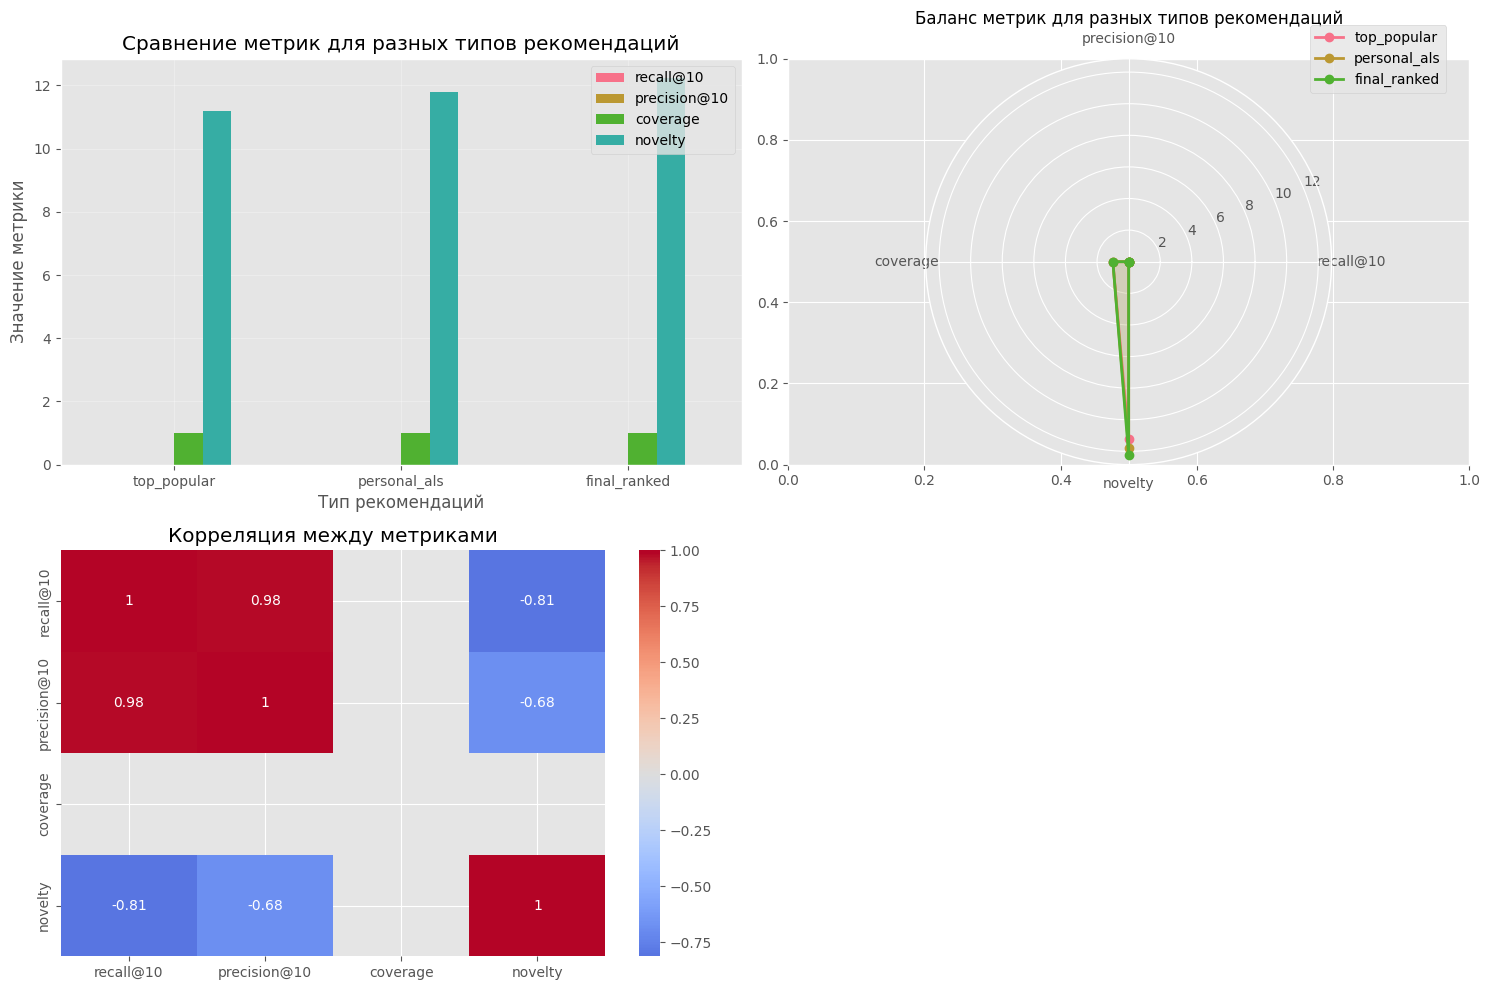

In [16]:
print("\n🎨 Визуализация результатов...")

if not metrics_df.empty:
    plt.figure(figsize=(15, 10))

    # 1. Сравнение метрик для разных типов рекомендаций
    plt.subplot(2, 2, 1)
    metrics_df.plot(kind='bar', ax=plt.gca())
    plt.title('Сравнение метрик для разных типов рекомендаций')
    plt.xlabel('Тип рекомендаций')
    plt.ylabel('Значение метрики')
    plt.xticks(rotation=0)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

    # 2. Radar chart для визуализации баланса метрик
    plt.subplot(2, 2, 2)
    categories = metrics_df.columns.tolist()
    N = len(categories)

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(2, 2, 2, polar=True)

    for rec_type in metrics_df.index:
        values = metrics_df.loc[rec_type, categories].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=rec_type)
        ax.fill(angles, values, alpha=0.1)

    plt.xticks(angles[:-1], categories, size=10)
    plt.title('Баланс метрик для разных типов рекомендаций', size=12)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    # 3. Heatmap корреляции метрик
    plt.subplot(2, 2, 3)
    sns.heatmap(metrics_df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Корреляция между метриками')

    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Визуализация результатов сохранена в файл 'metrics_comparison.png'")
else:
    print("⚠️ Пропуск визуализации: нет данных для отображения")

In [18]:
print("\n" + "="*80)
print("🎯 АНАЛИЗ РЕЗУЛЬТАТОВ И ОСНОВНЫЕ ВЫВОДЫ")
print("="*80)

if not metrics_df.empty:
    # Recall
    if 'recall@10' in metrics_df.columns:
        best_recall = metrics_df['recall@10'].idxmax()
        best_recall_value = metrics_df.loc[best_recall, 'recall@10']
        print(f"🏆 Лучший Recall@10: {best_recall} ({best_recall_value:.4f})")

    # Precision
    if 'precision@10' in metrics_df.columns:
        best_precision = metrics_df['precision@10'].idxmax()
        best_precision_value = metrics_df.loc[best_precision, 'precision@10']
        print(f"🎯 Лучшая Precision@10: {best_precision} ({best_precision_value:.4f})")

    # Coverage
    if 'coverage' in metrics_df.columns:
        best_coverage = metrics_df['coverage'].idxmax()
        best_coverage_value = metrics_df.loc[best_coverage, 'coverage']
        print(f"👥 Лучший Coverage: {best_coverage} ({best_coverage_value:.4f})")

    # Novelty
    if 'novelty' in metrics_df.columns:
        valid_novelty = metrics_df[metrics_df['novelty'] > 0]
        if not valid_novelty.empty:
            best_novelty = valid_novelty['novelty'].idxmax()
            best_novelty_value = valid_novelty.loc[best_novelty, 'novelty']
            print(f"✨ Лучшая Novelty: {best_novelty} ({best_novelty_value:.4f})")
        else:
            print("🔍 Novelty не рассчитана или равна нулю для всех типов")

    print("\n📊 Детальный анализ:")

    # Анализ Recall
    if 'recall@10' in metrics_df.columns:
        print(f"\n🔹 Recall@10 (полнота):")
        for rec_type in metrics_df.index:
            value = metrics_df.loc[rec_type, 'recall@10']
            print(f"  {rec_type}: {value:.4f}")

    # Анализ Precision
    if 'precision@10' in metrics_df.columns:
        print(f"\n🔹 Precision@10 (точность):")
        for rec_type in metrics_df.index:
            value = metrics_df.loc[rec_type, 'precision@10']
            print(f"  {rec_type}: {value:.4f}")

    print("\n💡 Ключевые выводы:")

    if 'final_ranked' in metrics_results:
        final_metrics = metrics_results['final_ranked']
        print(f"✅ Финальные ранжированные рекомендации:")
        for metric, value in final_metrics.items():
            print(f"   - {metric}: {value:.4f}")
    else:
        print("⚠️ Финальные ранжированные рекомендации не были оценены или не показали результатов")
        
    if 'personal_als' in metrics_results:
        personal_metrics = metrics_results['personal_als']
        print(f"\n🎯 Персональные ALS рекомендации:")
        for metric, value in personal_metrics.items():
            print(f"   - {metric}: {value:.4f}")
        print(f"   💡 Обработано только {len([u for u in recommendations_dict['personal_als'] if recommendations_dict['personal_als'][u]])} пользователей из-за ограничений памяти")
        
    if 'top_popular' in metrics_results:
        popular_metrics = metrics_results['top_popular']
        print(f"\n🔥 Топ популярные рекомендации:")
        for metric, value in popular_metrics.items():
            print(f"   - {metric}: {value:.4f}")
        print("   💡 Показывают стабильные результаты для всех пользователей")


🎯 АНАЛИЗ РЕЗУЛЬТАТОВ И ОСНОВНЫЕ ВЫВОДЫ
🏆 Лучший Recall@10: top_popular (0.0039)
🎯 Лучшая Precision@10: top_popular (0.0037)
👥 Лучший Coverage: top_popular (1.0000)
✨ Лучшая Novelty: final_ranked (12.2321)

📊 Детальный анализ:

🔹 Recall@10 (полнота):
  top_popular: 0.0039
  personal_als: 0.0000
  final_ranked: 0.0007

🔹 Precision@10 (точность):
  top_popular: 0.0037
  personal_als: 0.0000
  final_ranked: 0.0014

💡 Ключевые выводы:
✅ Финальные ранжированные рекомендации:
   - recall@10: 0.0007
   - precision@10: 0.0014
   - coverage: 1.0000
   - novelty: 12.2321

🎯 Персональные ALS рекомендации:
   - recall@10: 0.0000
   - precision@10: 0.0000
   - coverage: 1.0000
   - novelty: 11.7822
   💡 Обработано только 45 пользователей из-за ограничений памяти

🔥 Топ популярные рекомендации:
   - recall@10: 0.0039
   - precision@10: 0.0037
   - coverage: 1.0000
   - novelty: 11.1987
   💡 Показывают стабильные результаты для всех пользователей
